In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 20 11:12:31 2025

@author: aglabassi
"""

!git clone https://github.com/aglabassi/preconditioned_composite_opti temp_repo
!mv temp_repo/* ./
!rm -rf temp_repo

#!sudo apt update
#!sudo apt upgrade -y

!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended



import os
import torch
import pickle
from plotting_utils  import collect_compute_mean,\
 plot_losses_with_styles, plot_transition_heatmap, plot_results_sensitivity
from run_matrix_tensor_experiments import run_matrix_tensor_sensing_experiments
from run_hadamard_experiments import  run_nonegative_least_squares_experiments
from itertools import product

from google.colab import drive
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/preconditioned_gradient_descent'

# Set device to GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

def save(obj, filename):
    """Saves an object to a file using pickle."""
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)
    print(f"Object saved to {filename}")

def load(filename):
    """Loads an object from a file using pickle."""
    with open(filename, 'rb') as f:
        obj = pickle.load(f)
    print(f"Object loaded from {filename}")
    return obj

torch.manual_seed(10)
torch.cuda.manual_seed(10)
torch.cuda.manual_seed_all(10)
torch.set_default_dtype(torch.float64)



Cloning into 'temp_repo'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 40 (delta 18), reused 21 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 2.33 MiB | 12.28 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2021.20220204-1).
texlive-latex-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Mounted at /content/drive
Running on device: cuda


# **Experiment 0: Introduction Example**



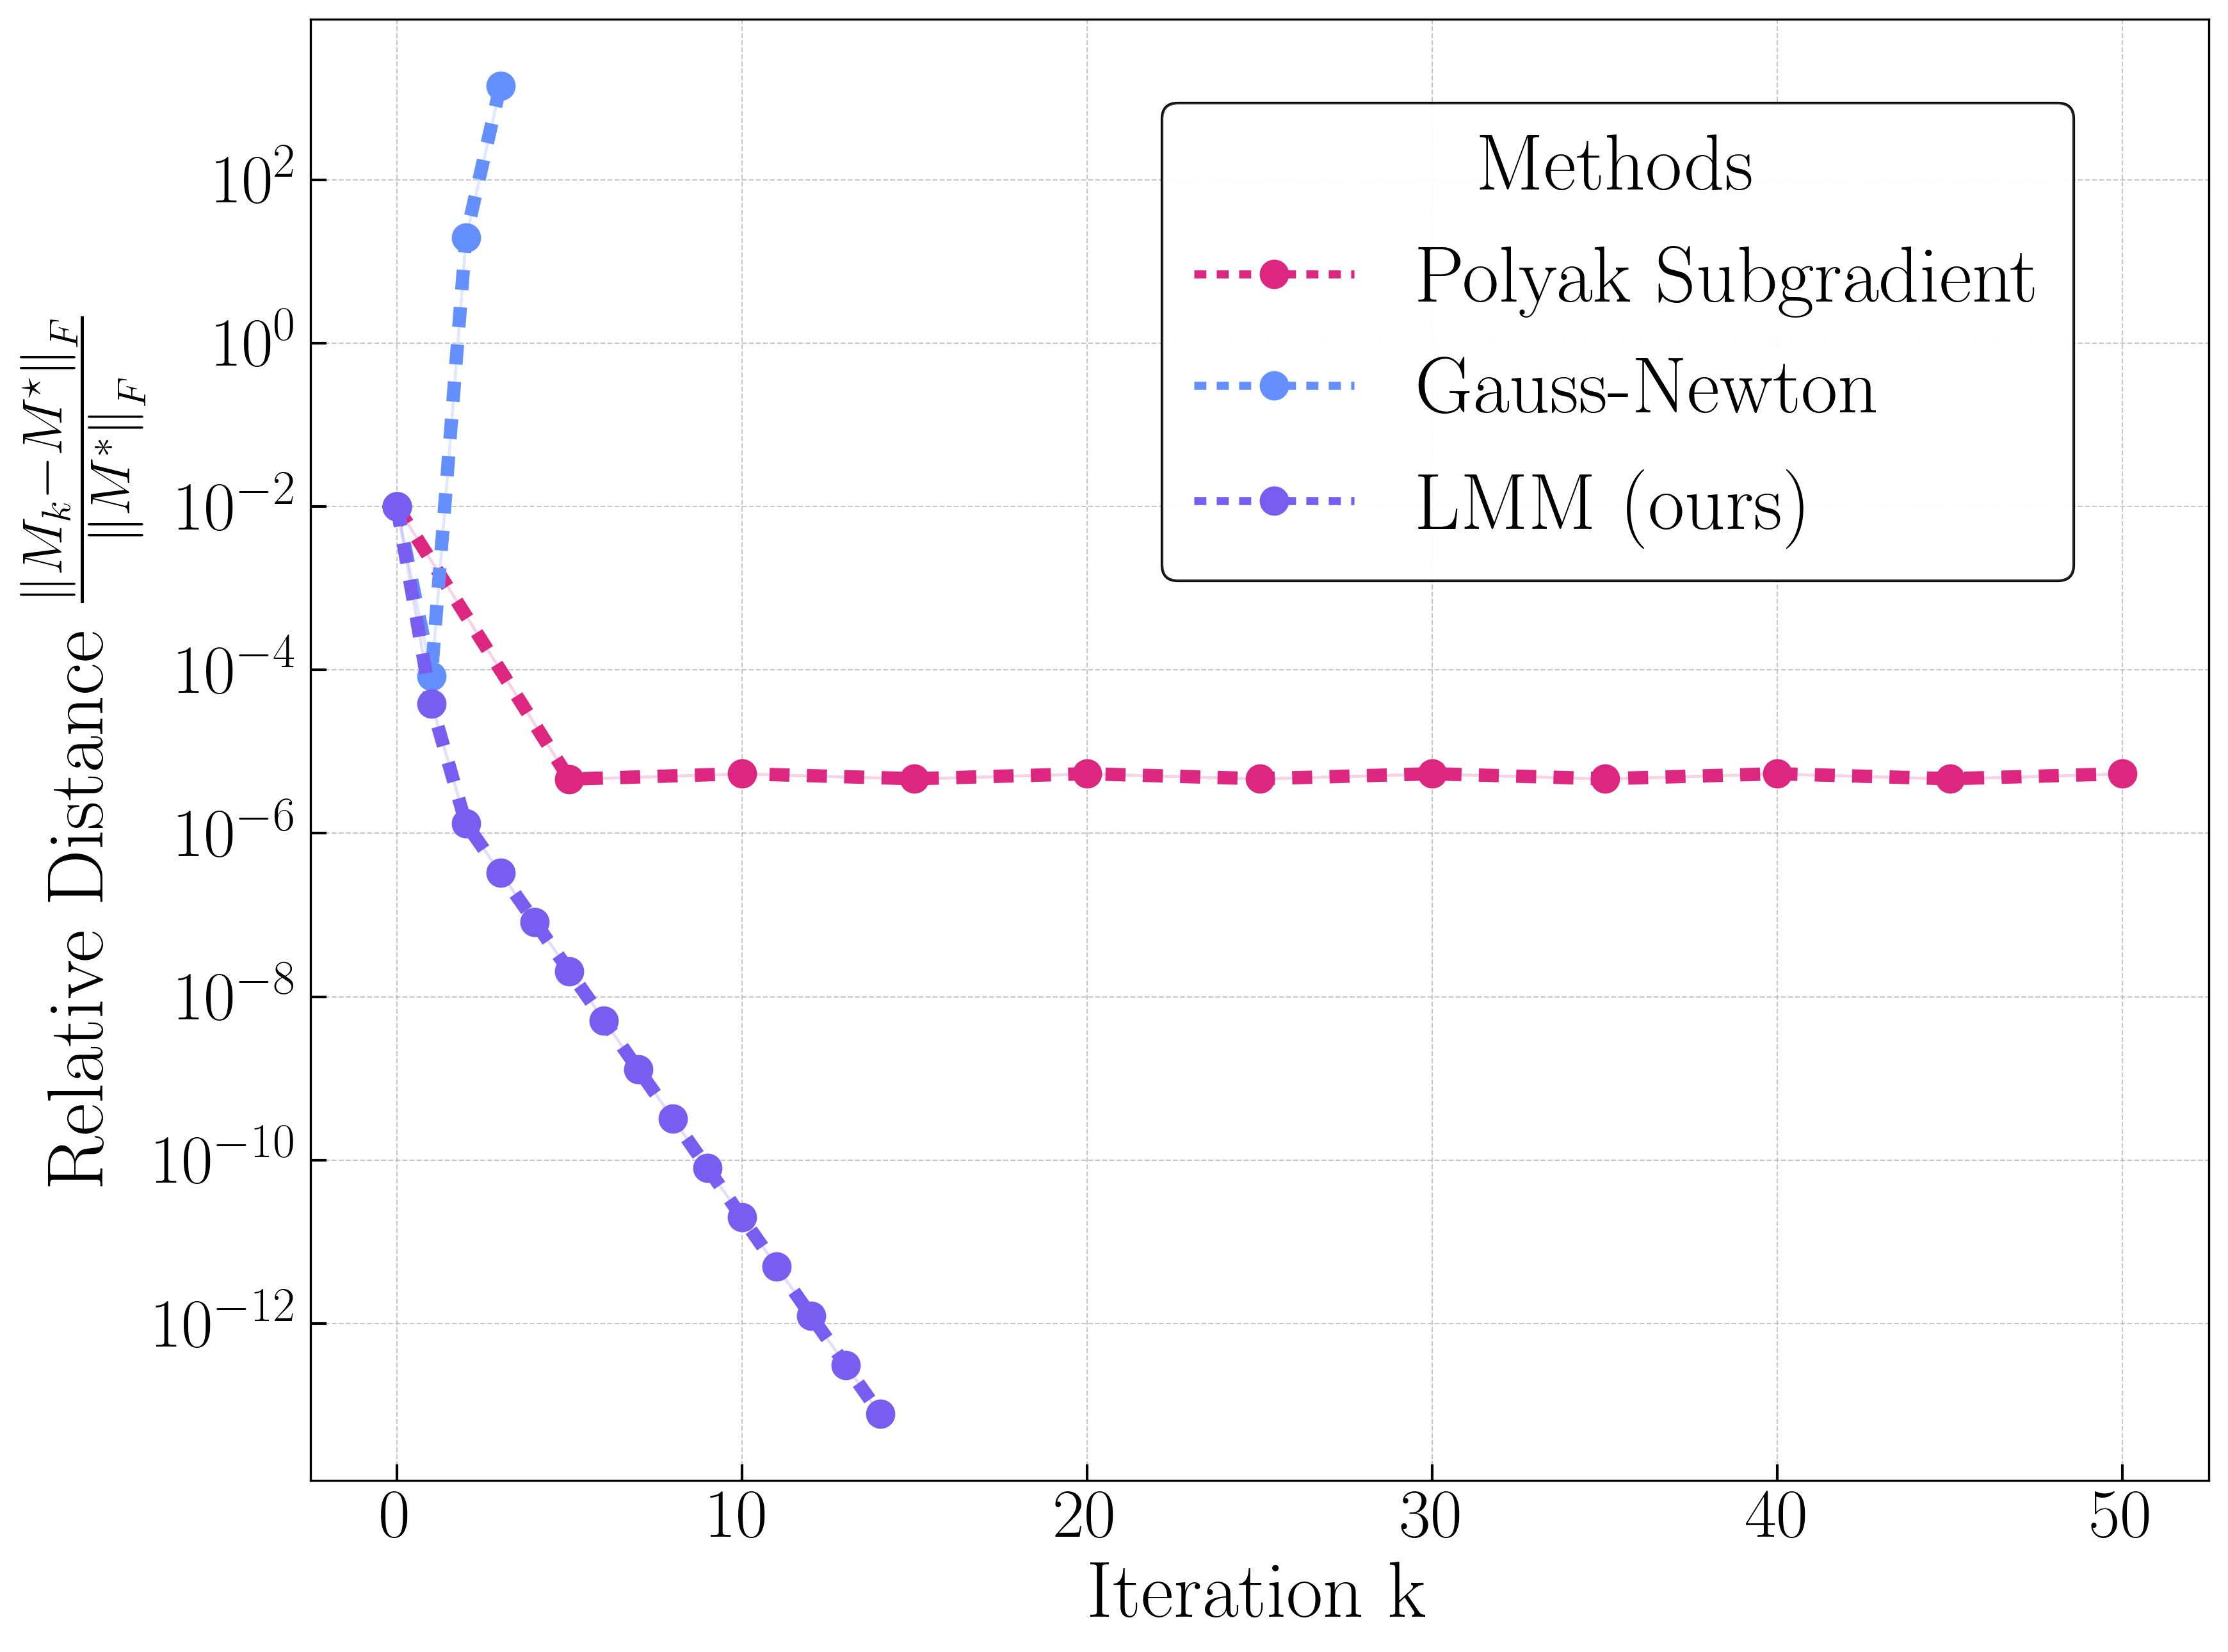

In [ ]:
#Repeat until Gauss-Newton diverges. It will diverge at some point. Use polyak stepsize with gamma=1.
n1 = 50
n2=  50
r_true = 2

tensor = False  #Symmetric Matrix Factorization
symmetric = True
identity = True

base_dir = os.path.join(save_path, 'experiment_results/polyak')
os.makedirs(base_dir, exist_ok=True)
loss_ord = 0.5 #L2 norm not squared
initial_relative_error = 10**-2
n_iter = 50

# Experiment_setups: (overparameterization, condition number)
experiment_setups = [(3, 1)]

methods = methods_test=  ['Levenberg-Marquardt (ours)', 'Gauss-Newton', 'Polyak Subgradient']

#run_matrix_tensor_sensing_experiments(methods_test, experiment_setups, n1, n2, 0, r_true, 0, identity, device,
#        n_iter, base_dir, loss_ord, initial_relative_error, symmetric,
#        tensor=tensor, gamma_custom=1)

errs, stds, times = collect_compute_mean(experiment_setups, loss_ord, r_true, False, methods,
                              f'{"tensor" if tensor else "matrix"}{"sym" if symmetric else ""}', base_dir
                                )

plot_losses_with_styles(errs, stds, r_true, loss_ord, base_dir,
                      (('Symmetric ' if symmetric else 'Asymmetric ') +
                      ('Tensor' if tensor else 'Matrix')), 1, intro_plot=True)

# **Experiment 1: Exact observations with Polyak Stepsizes**



      Polyak Subgradient       | Iteration: 000 | Relative Error: 1.000e+00
      Polyak Subgradient       | Iteration: 020 | Relative Error: 1.812e-02
      Polyak Subgradient       | Iteration: 040 | Relative Error: 2.116e-03
      Polyak Subgradient       | Iteration: 060 | Relative Error: 4.448e-04
      Polyak Subgradient       | Iteration: 080 | Relative Error: 1.096e-04
      Polyak Subgradient       | Iteration: 100 | Relative Error: 4.089e-05
      Polyak Subgradient       | Iteration: 120 | Relative Error: 8.239e-06
      Polyak Subgradient       | Iteration: 140 | Relative Error: 8.862e-07
      Polyak Subgradient       | Iteration: 160 | Relative Error: 2.431e-07
      Polyak Subgradient       | Iteration: 180 | Relative Error: 5.955e-08
      Polyak Subgradient       | Iteration: 200 | Relative Error: 1.648e-08
      Polyak Subgradient       | Iteration: 220 | Relative Error: 5.817e-09
      Polyak Subgradient       | Iteration: 240 | Relative Error: 3.177e-09
      Polyak

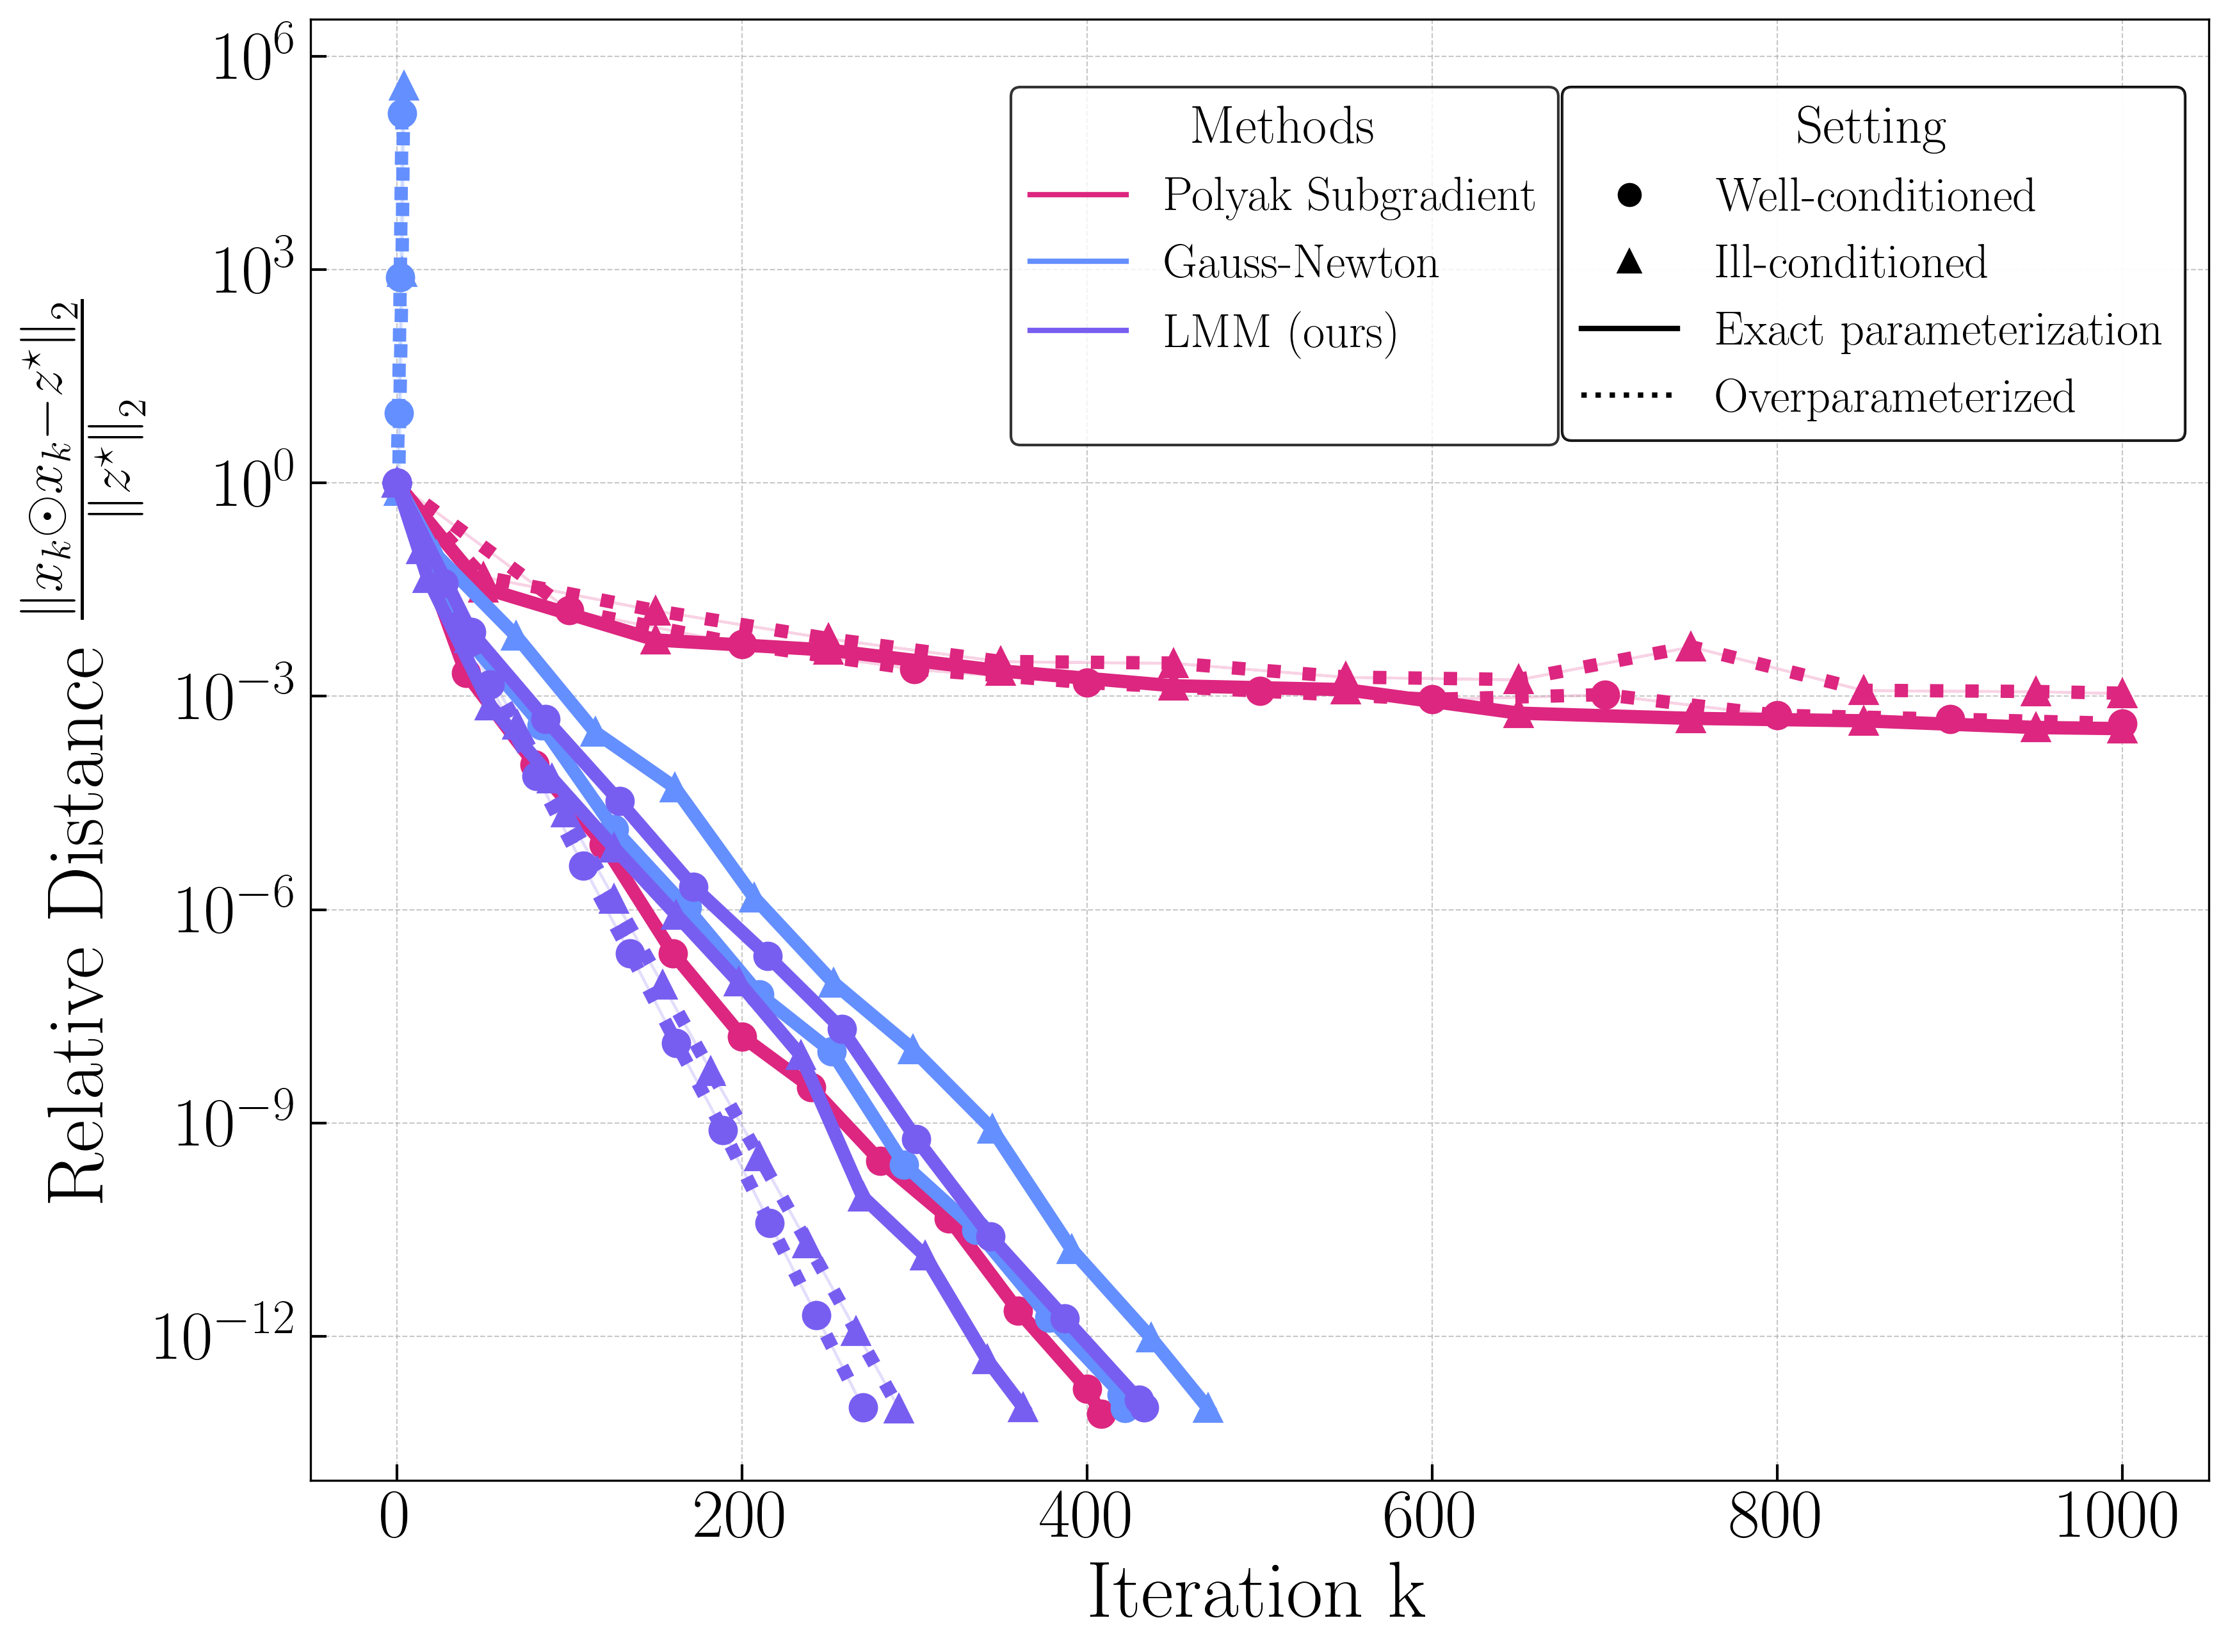

      Polyak Subgradient       | Iteration: 000 | Relative Error: 1.000e+00
      Polyak Subgradient       | Iteration: 020 | Relative Error: 1.935e-01
      Polyak Subgradient       | Iteration: 040 | Relative Error: 7.538e-02
      Polyak Subgradient       | Iteration: 060 | Relative Error: 2.170e-02
      Polyak Subgradient       | Iteration: 080 | Relative Error: 8.475e-03
      Polyak Subgradient       | Iteration: 100 | Relative Error: 2.799e-03
      Polyak Subgradient       | Iteration: 120 | Relative Error: 1.045e-03
      Polyak Subgradient       | Iteration: 140 | Relative Error: 3.714e-04
      Polyak Subgradient       | Iteration: 160 | Relative Error: 1.313e-04
      Polyak Subgradient       | Iteration: 180 | Relative Error: 5.219e-05
      Polyak Subgradient       | Iteration: 200 | Relative Error: 1.912e-05
      Polyak Subgradient       | Iteration: 220 | Relative Error: 1.055e-05
      Polyak Subgradient       | Iteration: 240 | Relative Error: 3.516e-06
      Polyak

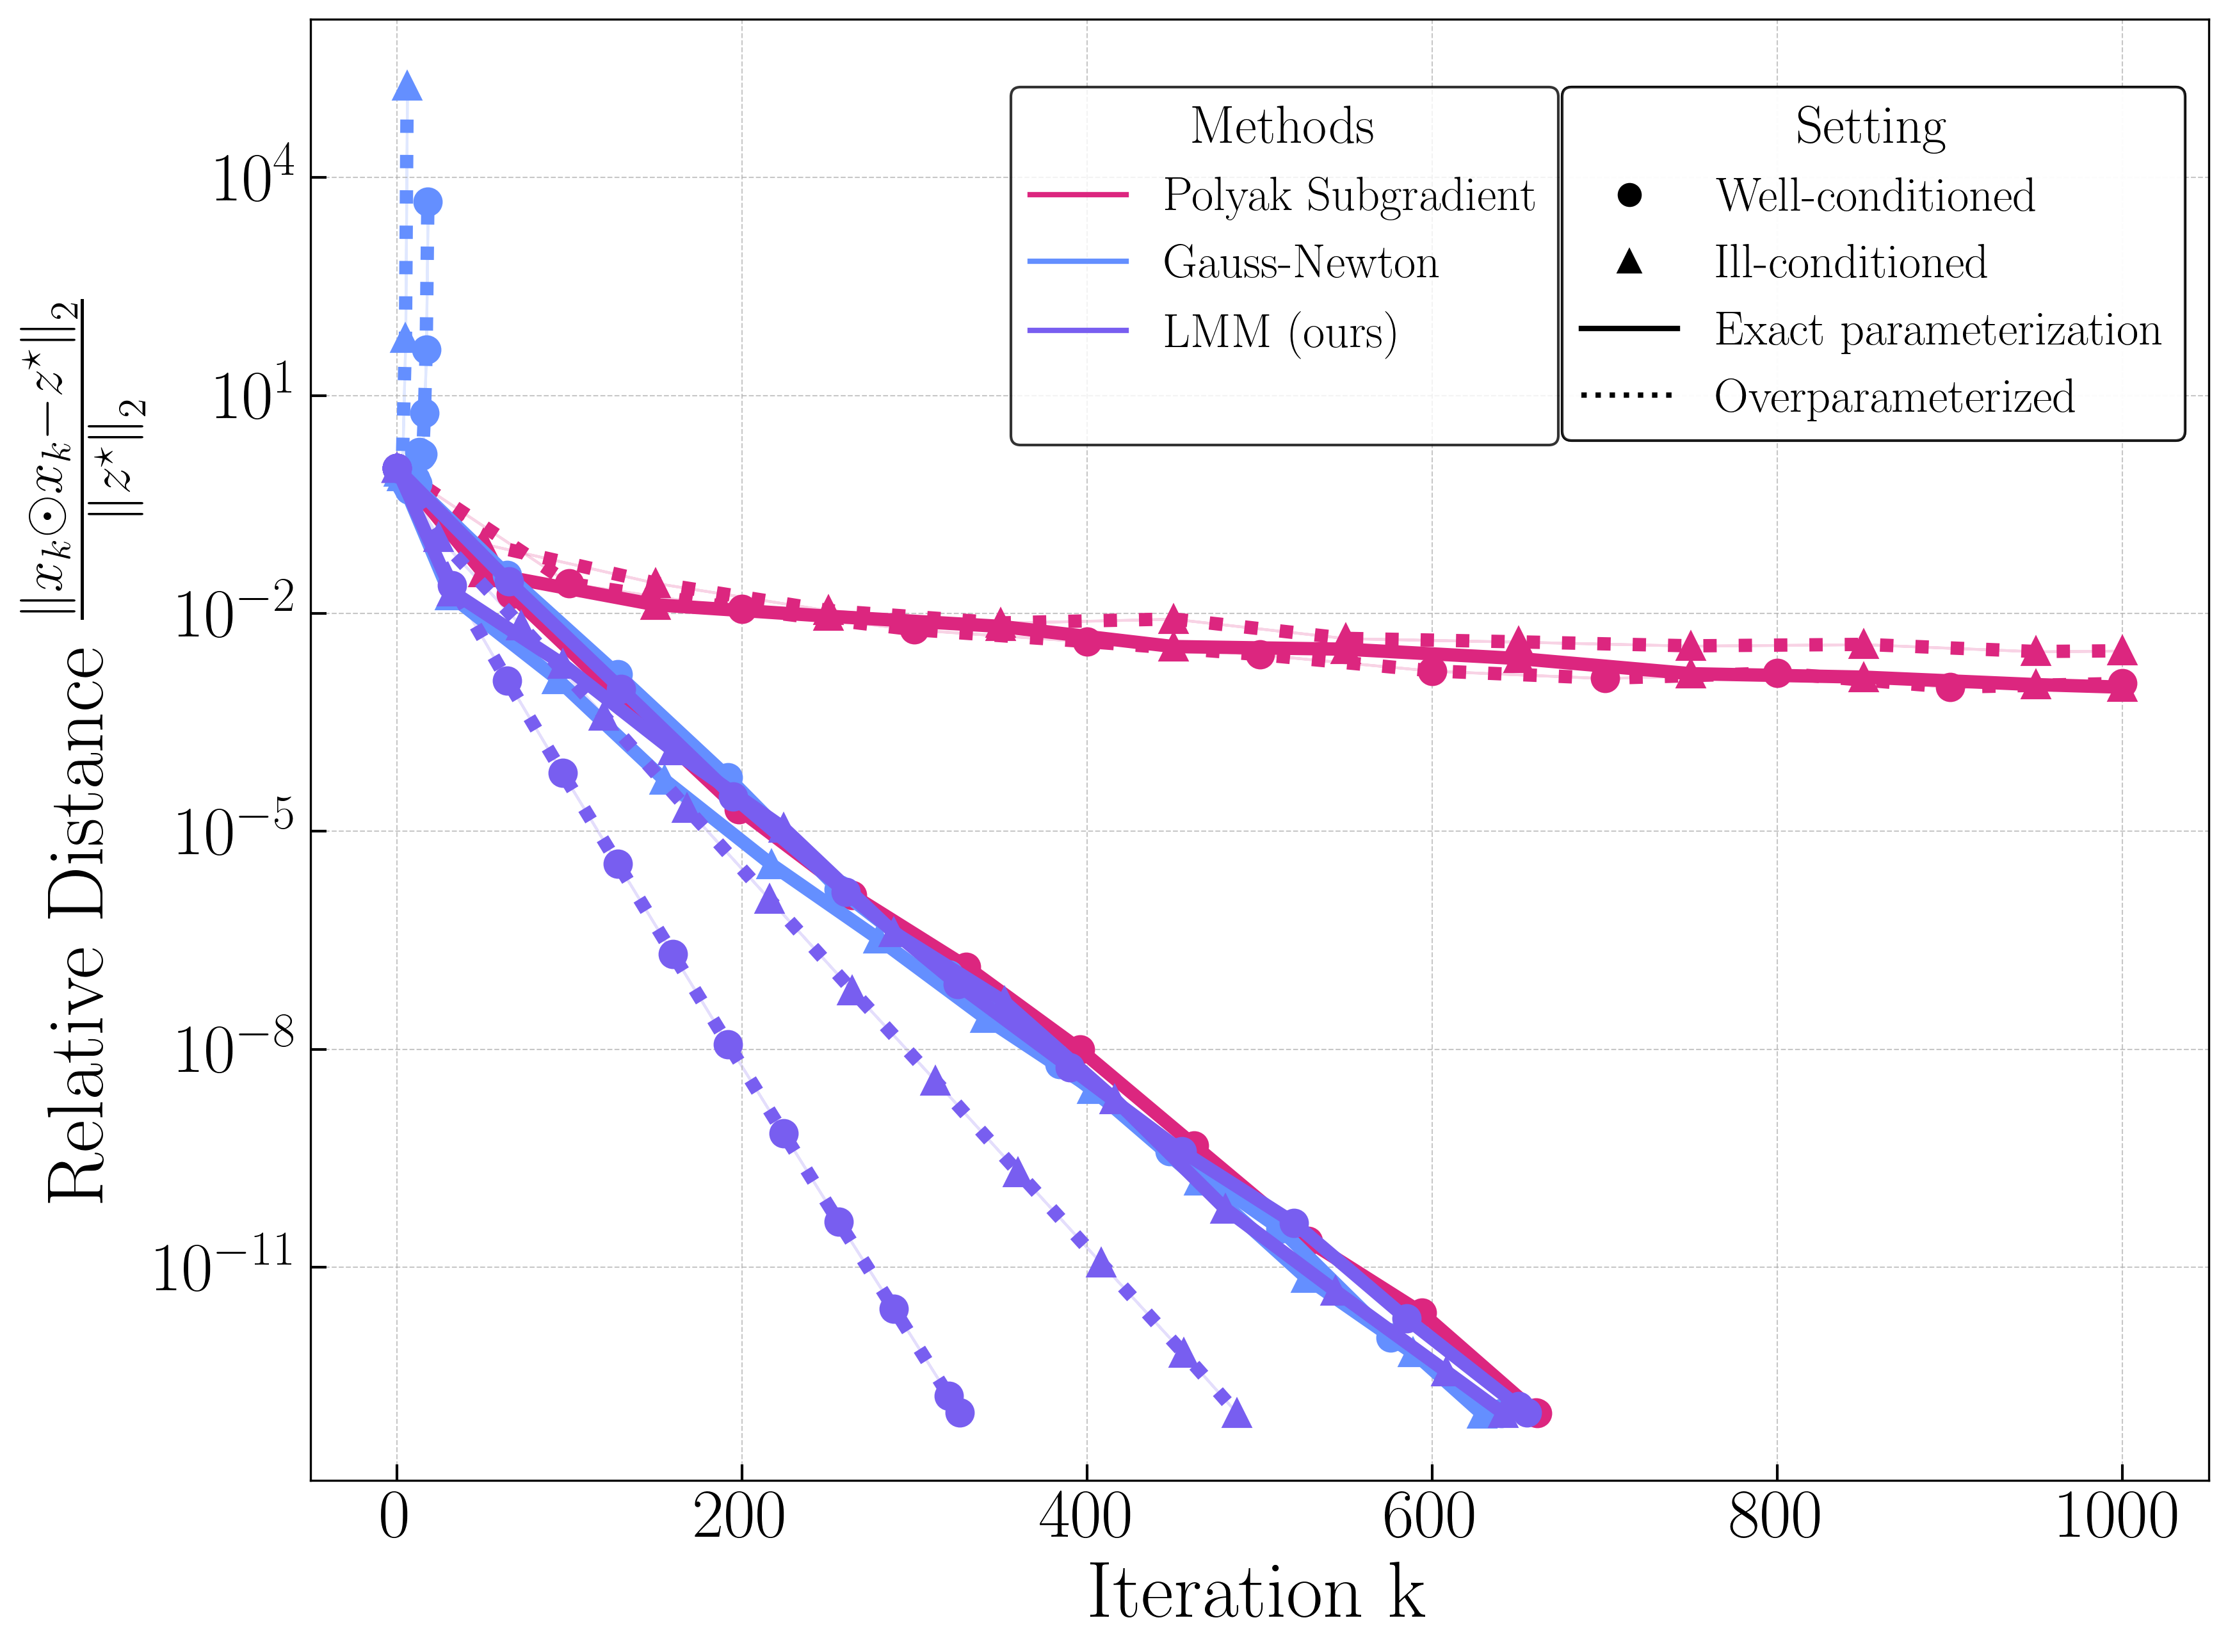

In [ ]:
#nonegative least squares
r_true = 10
r=100

kappa = 1
experiment_setups = [(r_true,1),(r,100), (r,1),(r_true,100)]
n_trial = 1
methods_test = methods = ['Polyak Subgradient', 'Levenberg-Marquardt (ours)', 'Gauss-Newton']
n_iter = 1000
loss_ords = [0.5,2]
for loss_ord in loss_ords:
  run_nonegative_least_squares_experiments(methods_test, experiment_setups, r_true,
                  1, device,
                  n_iter, base_dir, 1,loss_ord)

  errs, stds,_ = collect_compute_mean(experiment_setups, loss_ord, r_true, False, methods,
                                'had', base_dir)

  plot_losses_with_styles(errs, stds, r_true, loss_ord, base_dir,
                        'Hadamard', 1, had=True)

False


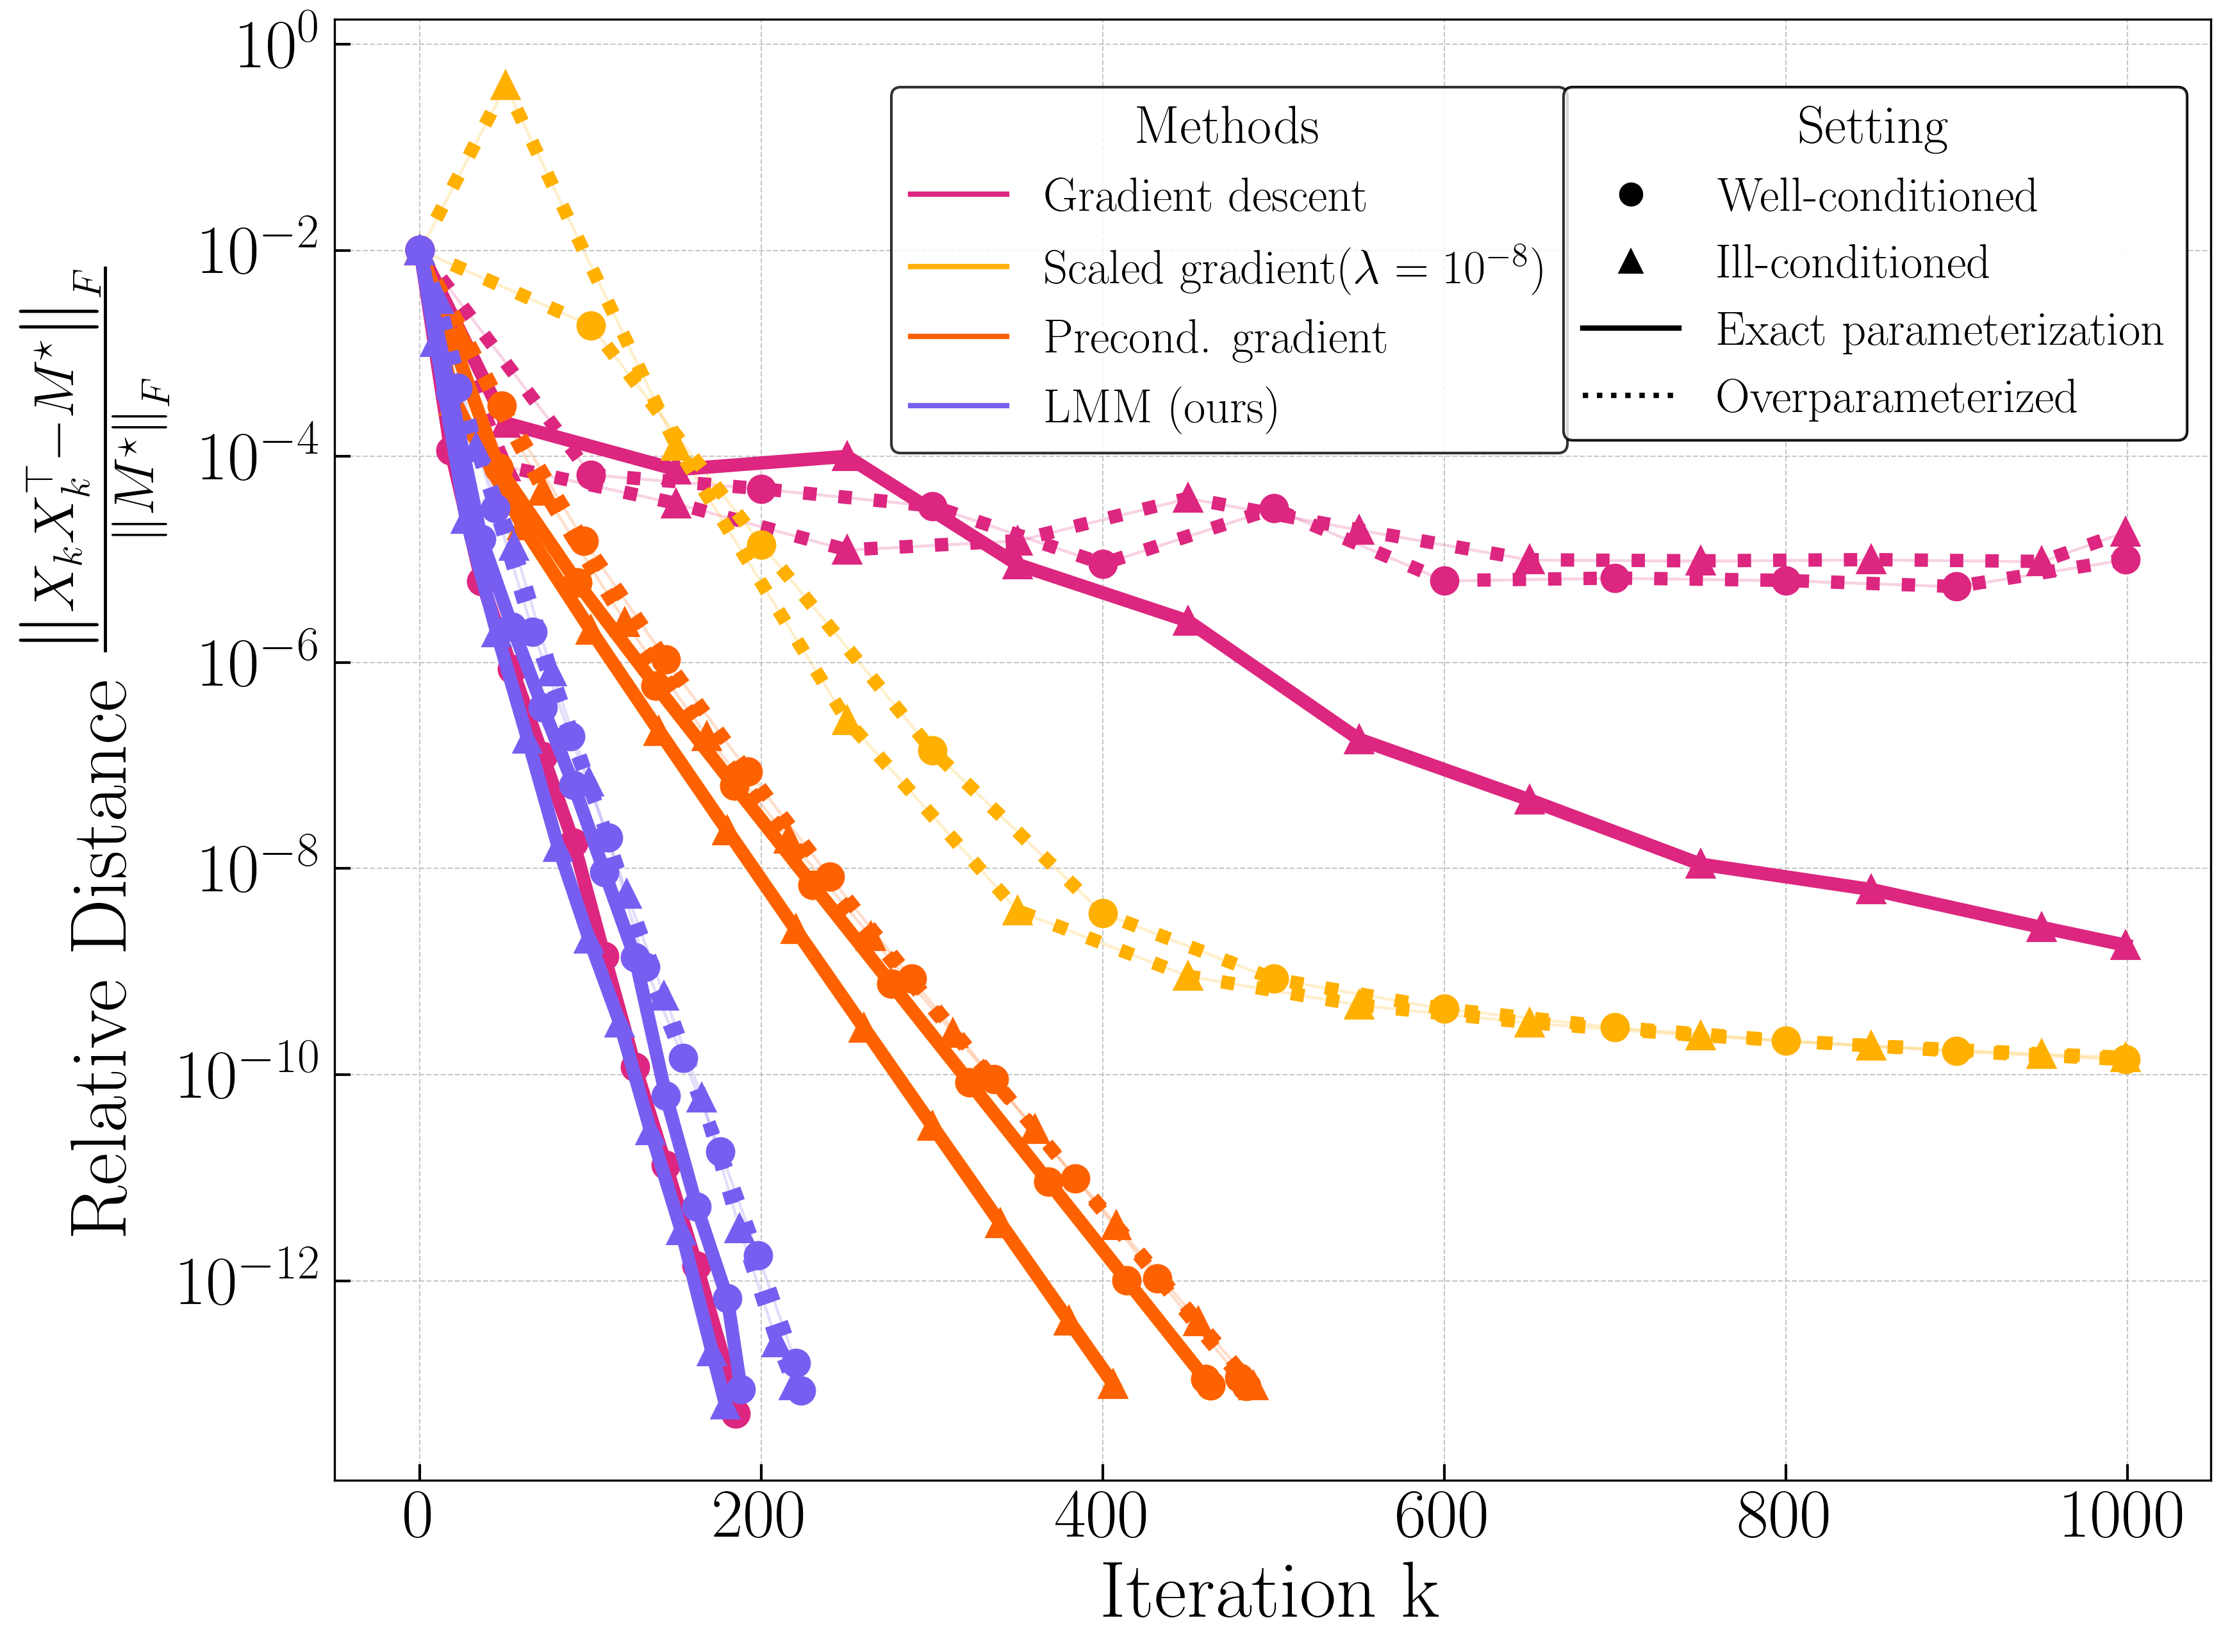

False


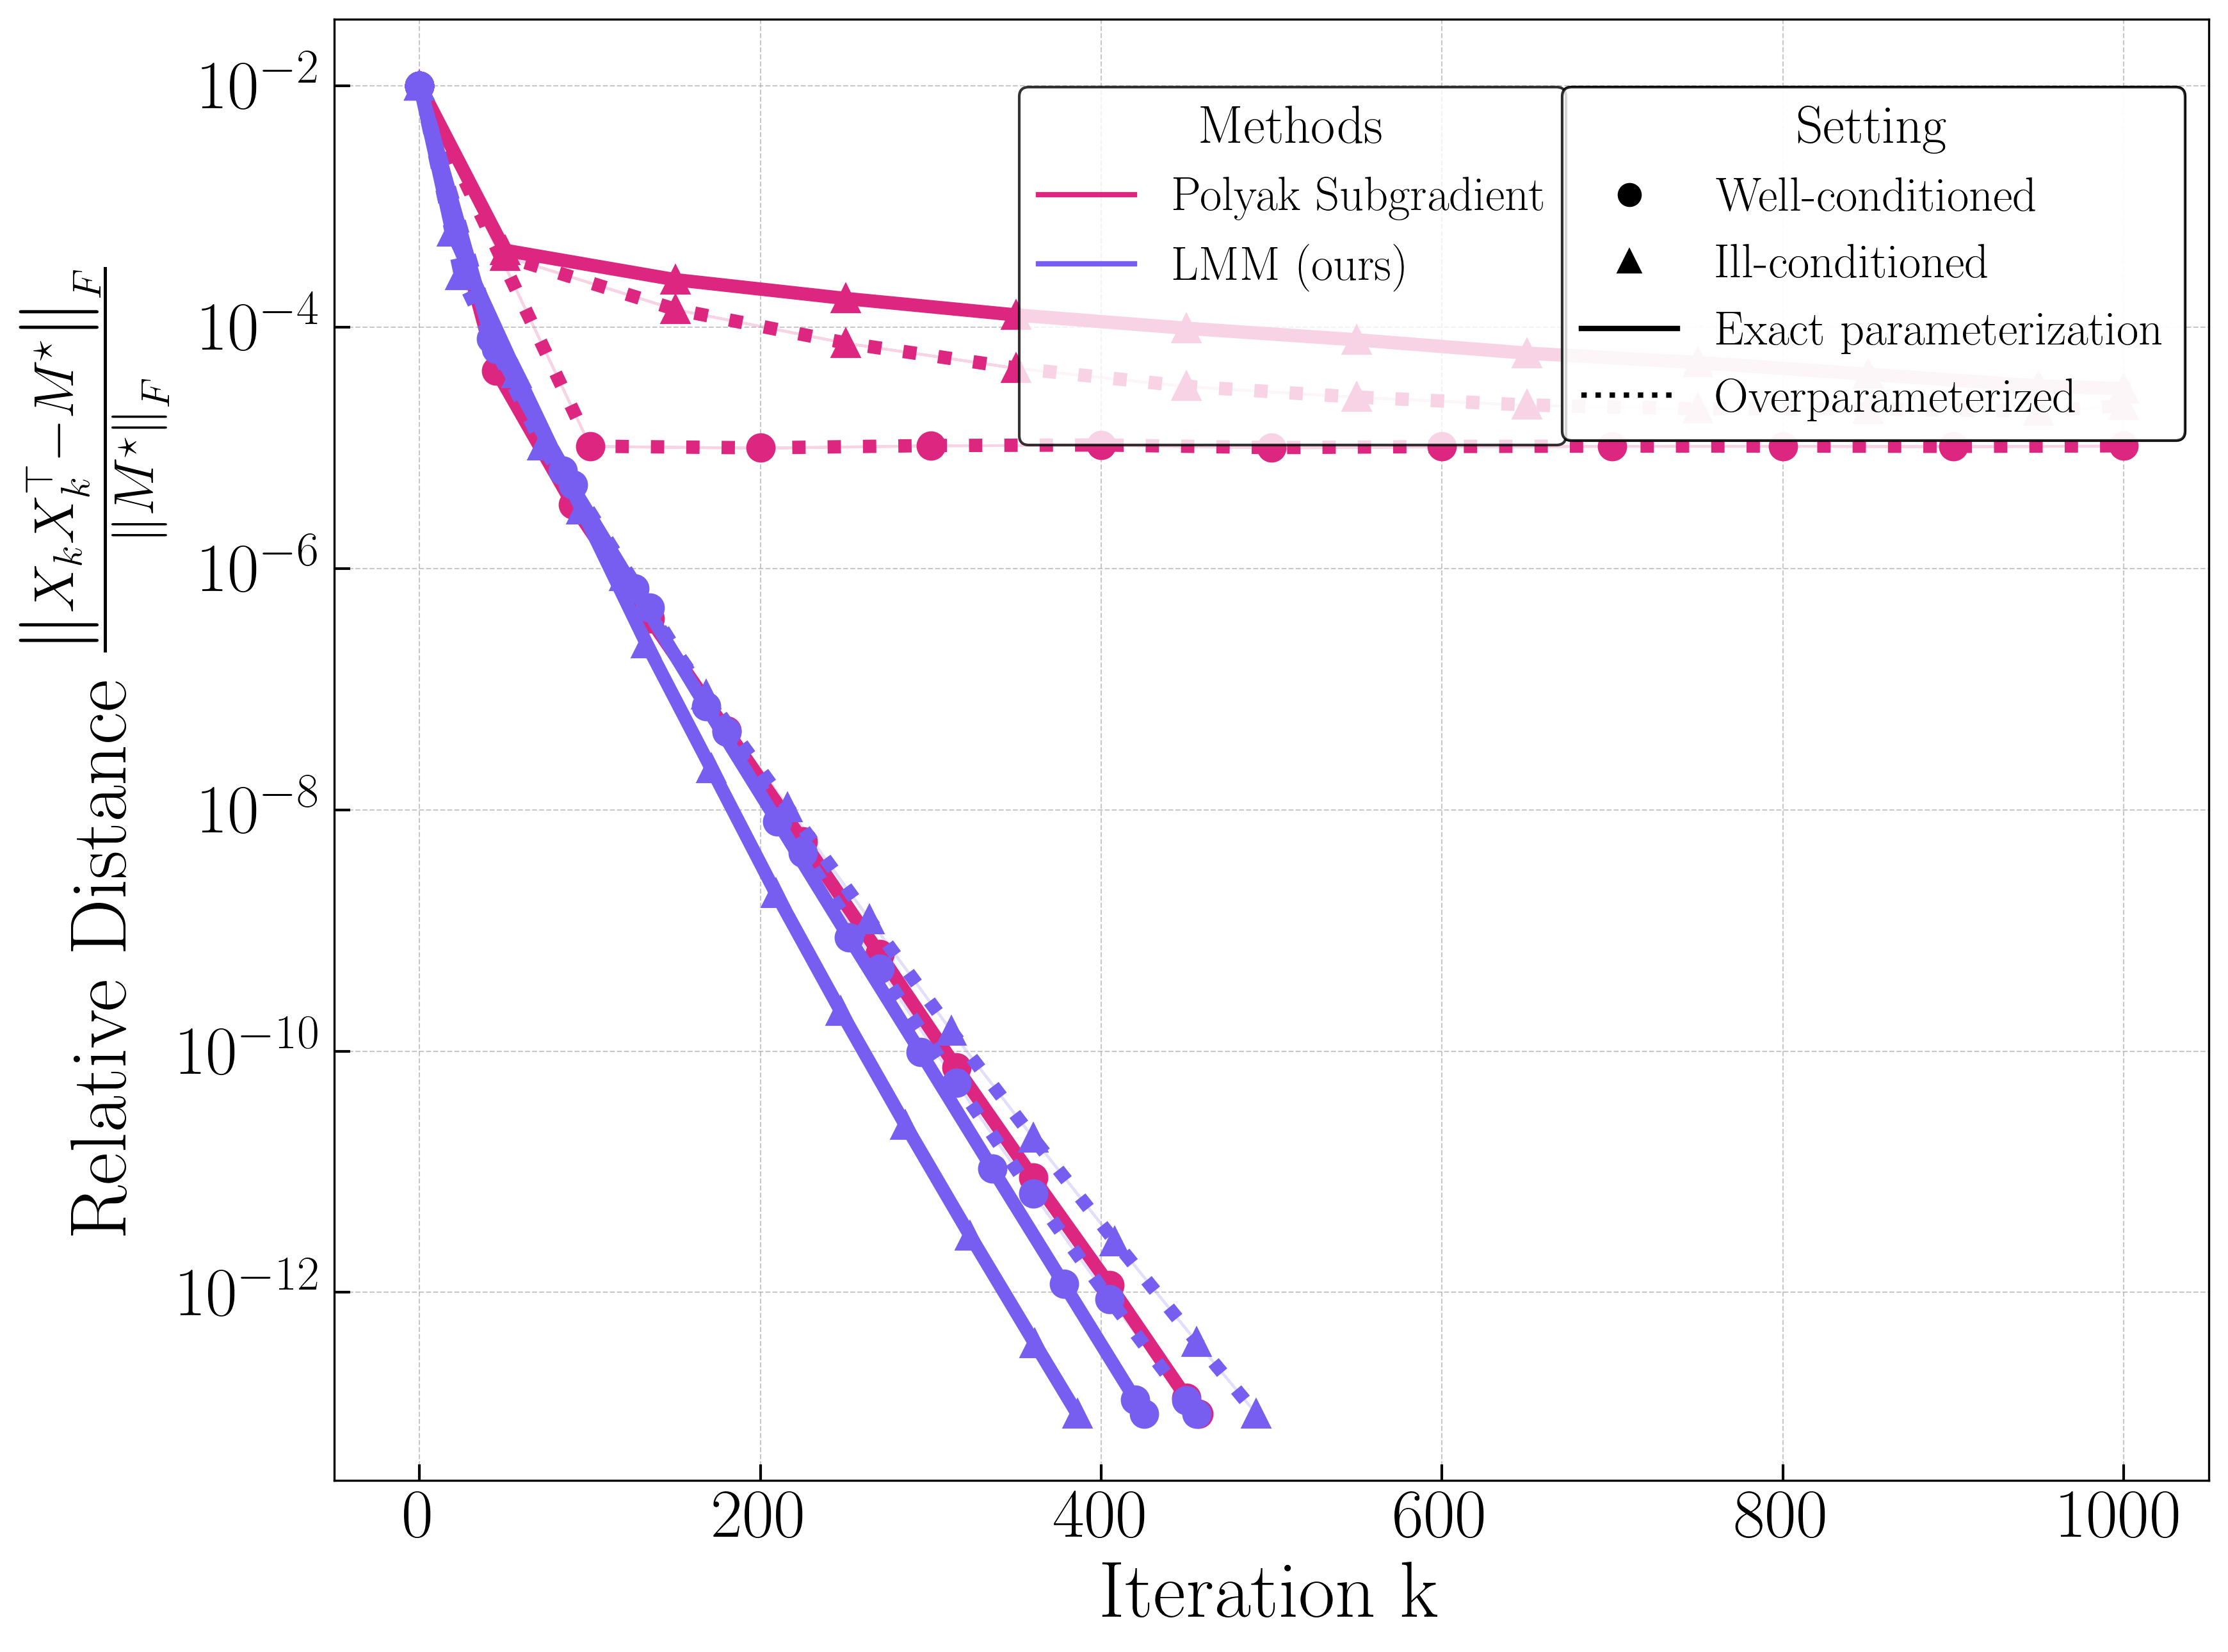

False


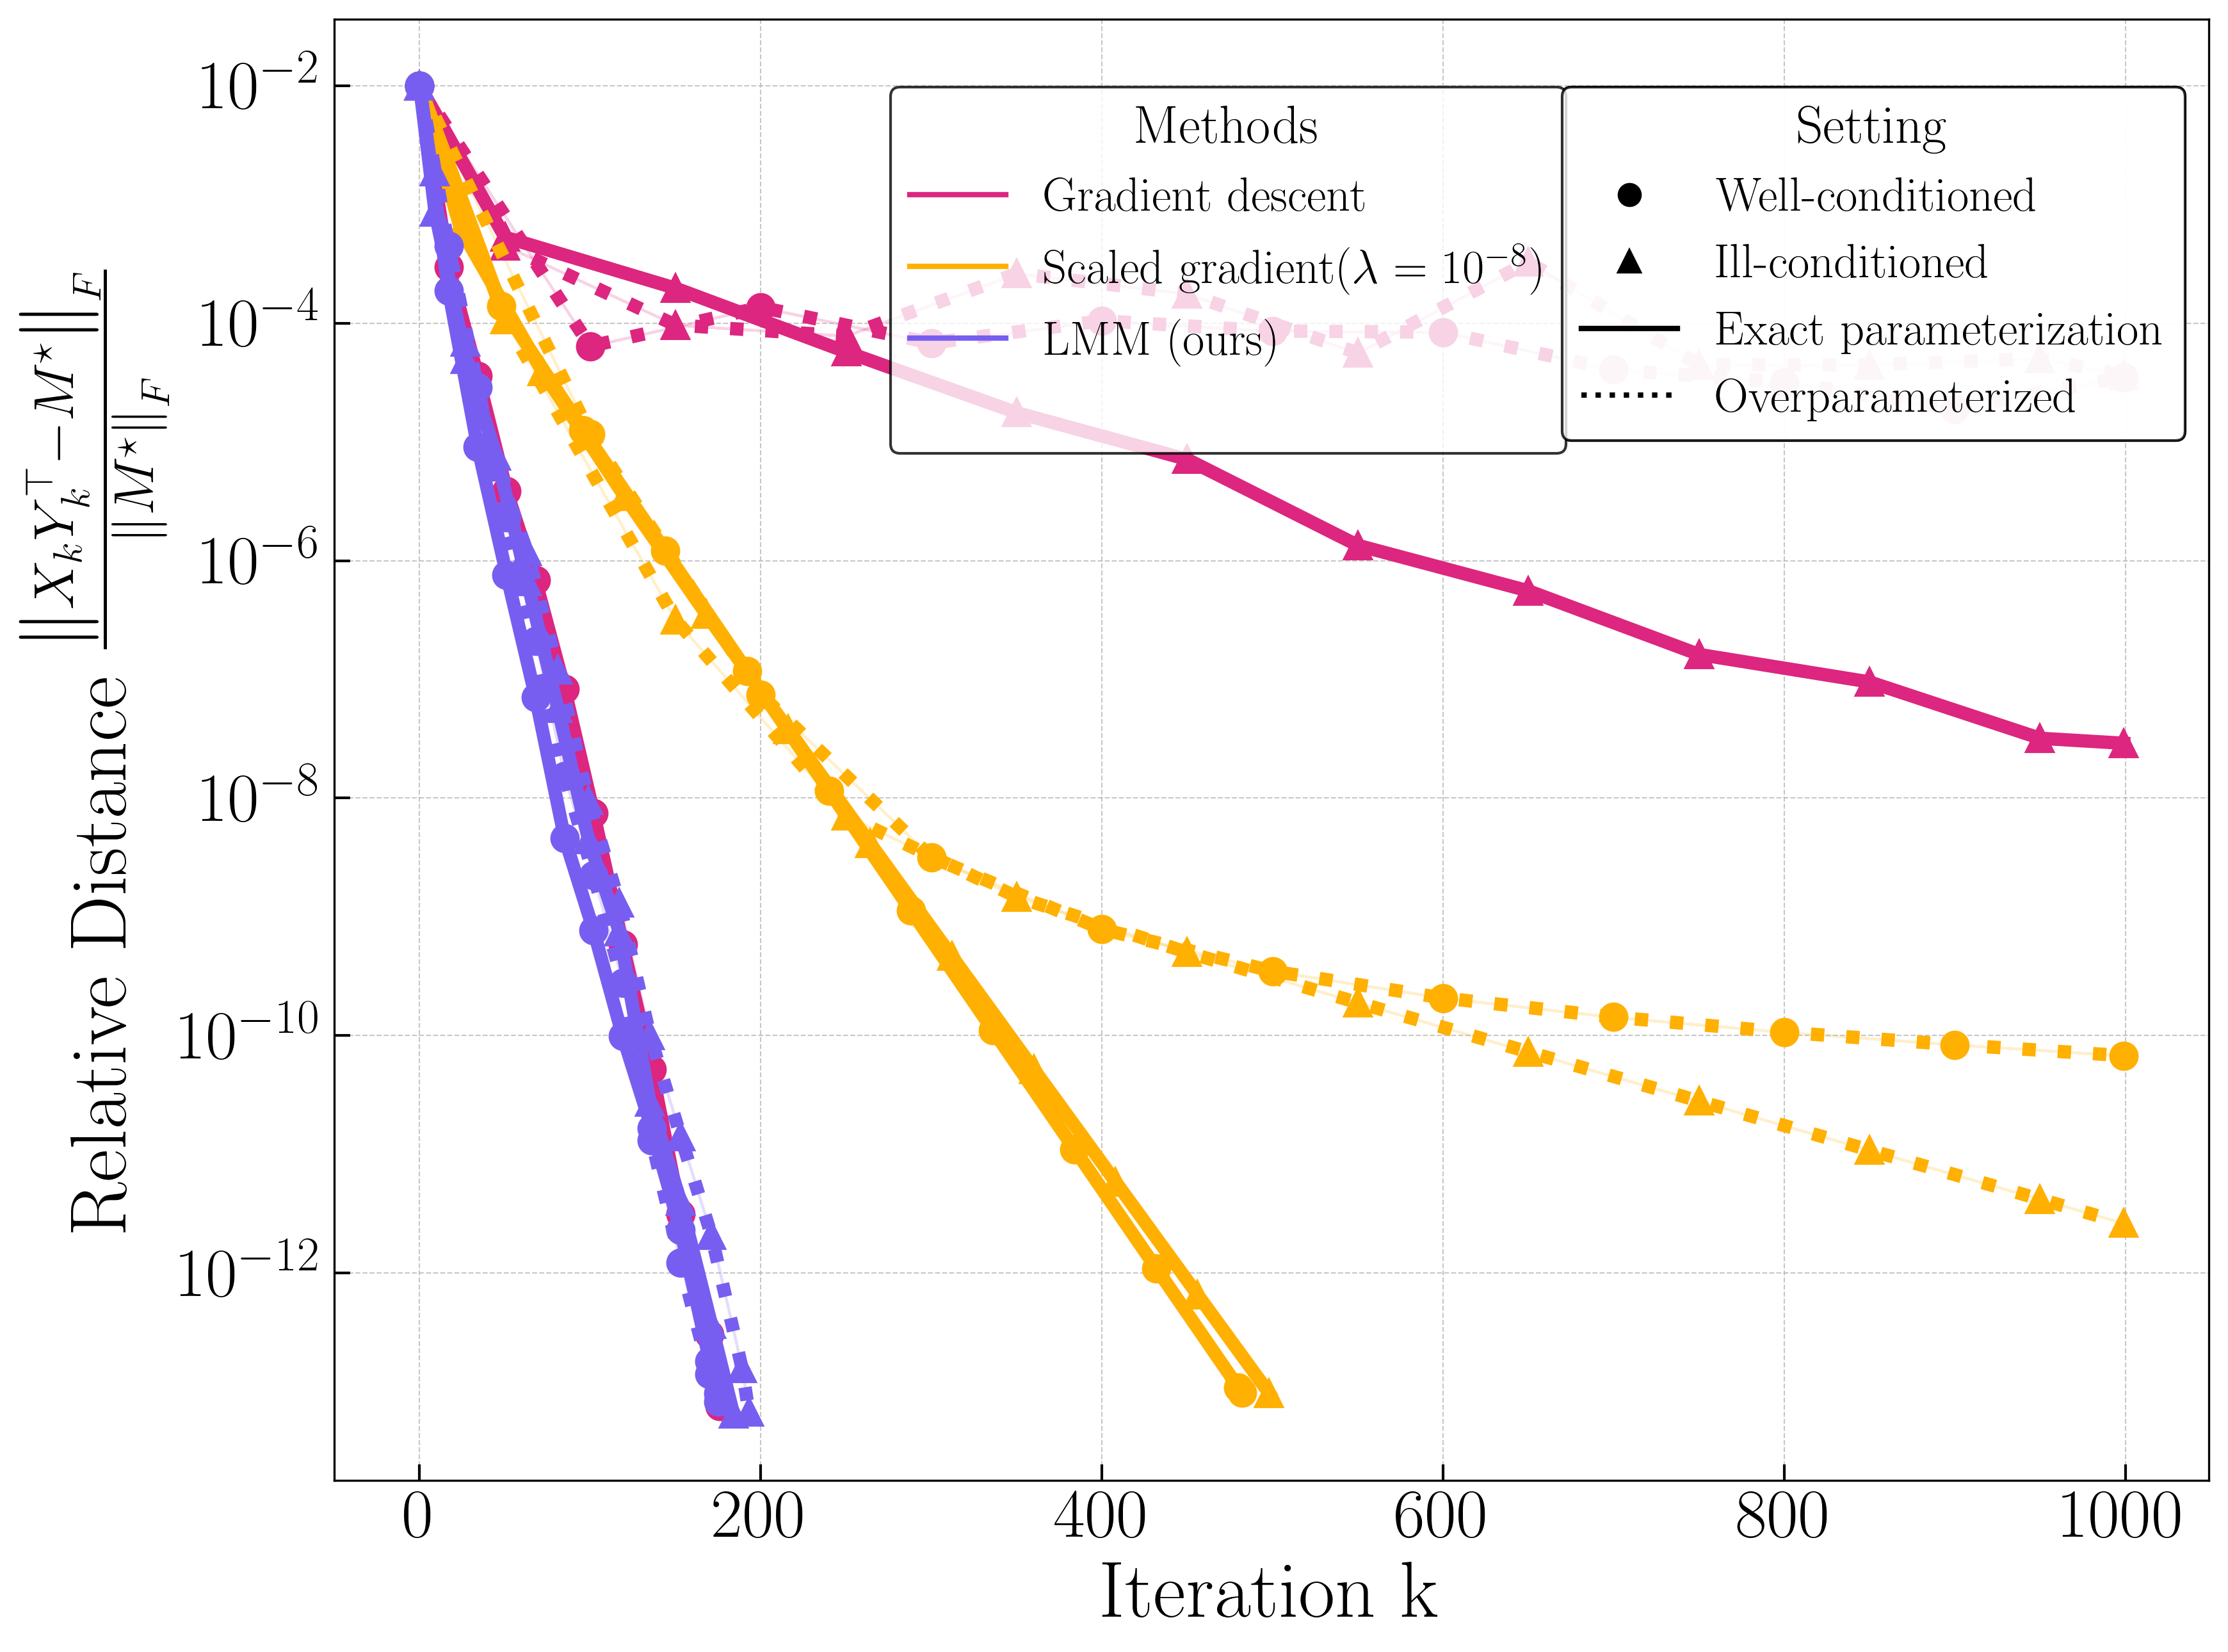

False


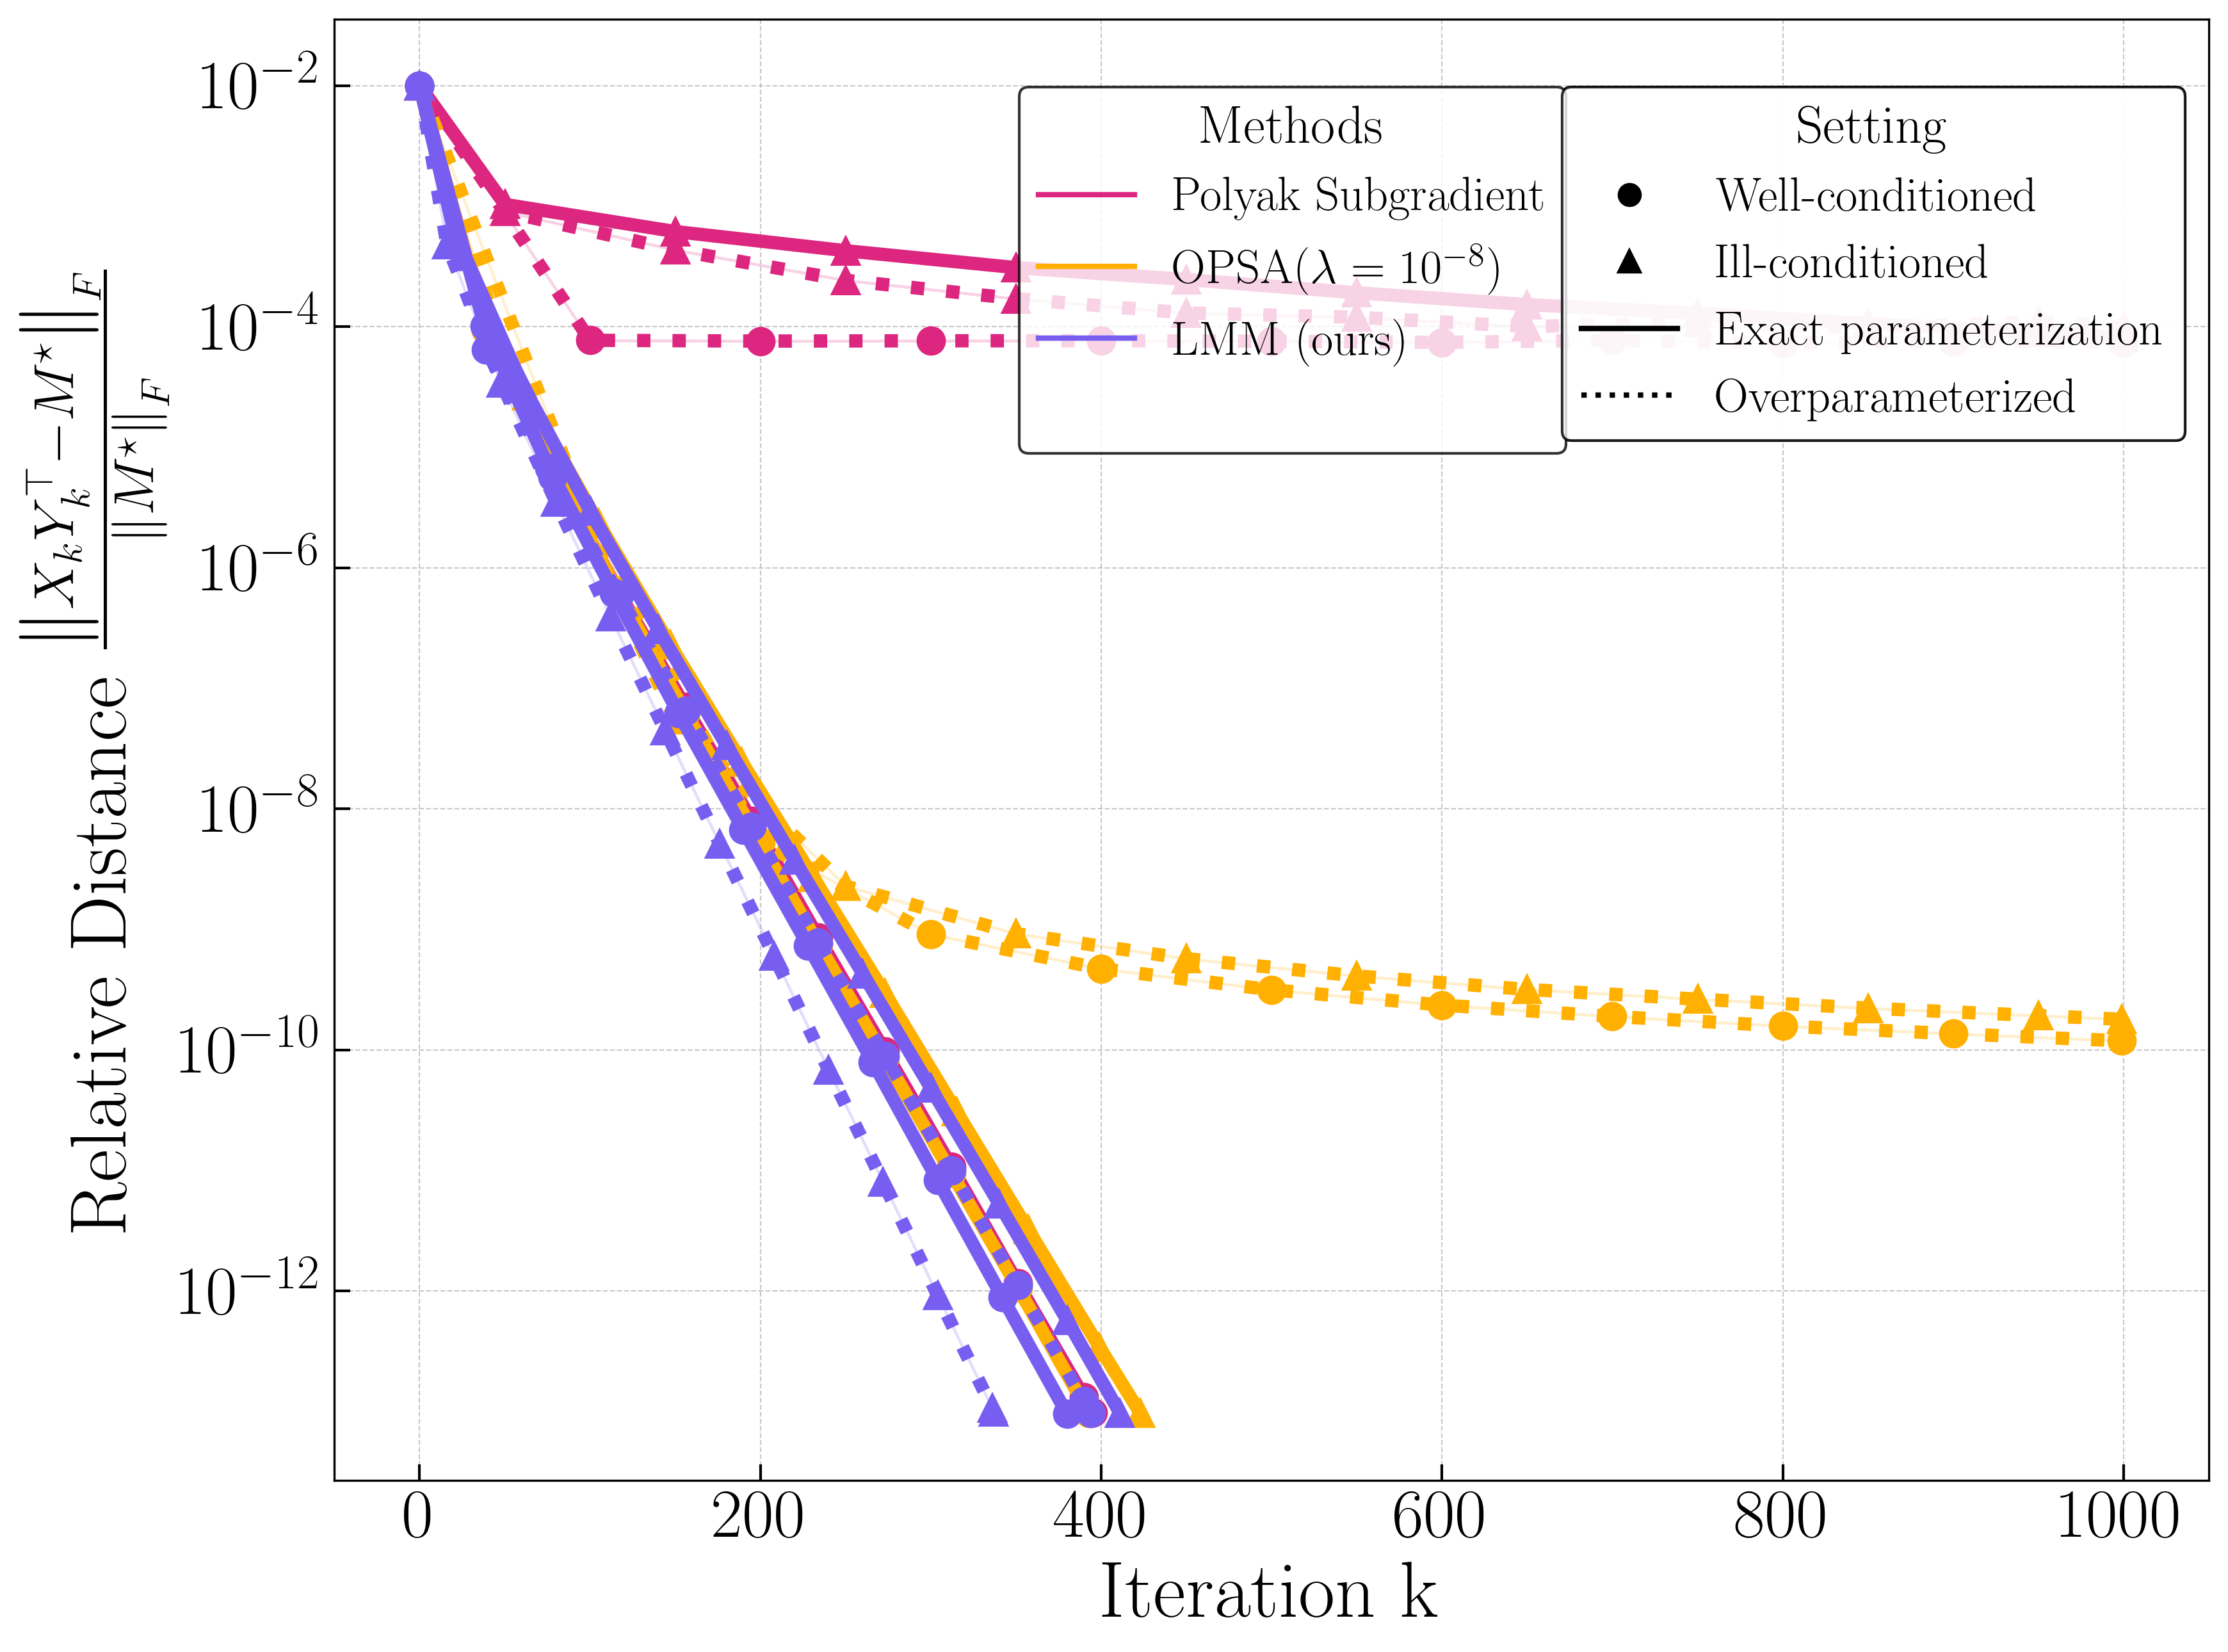

False


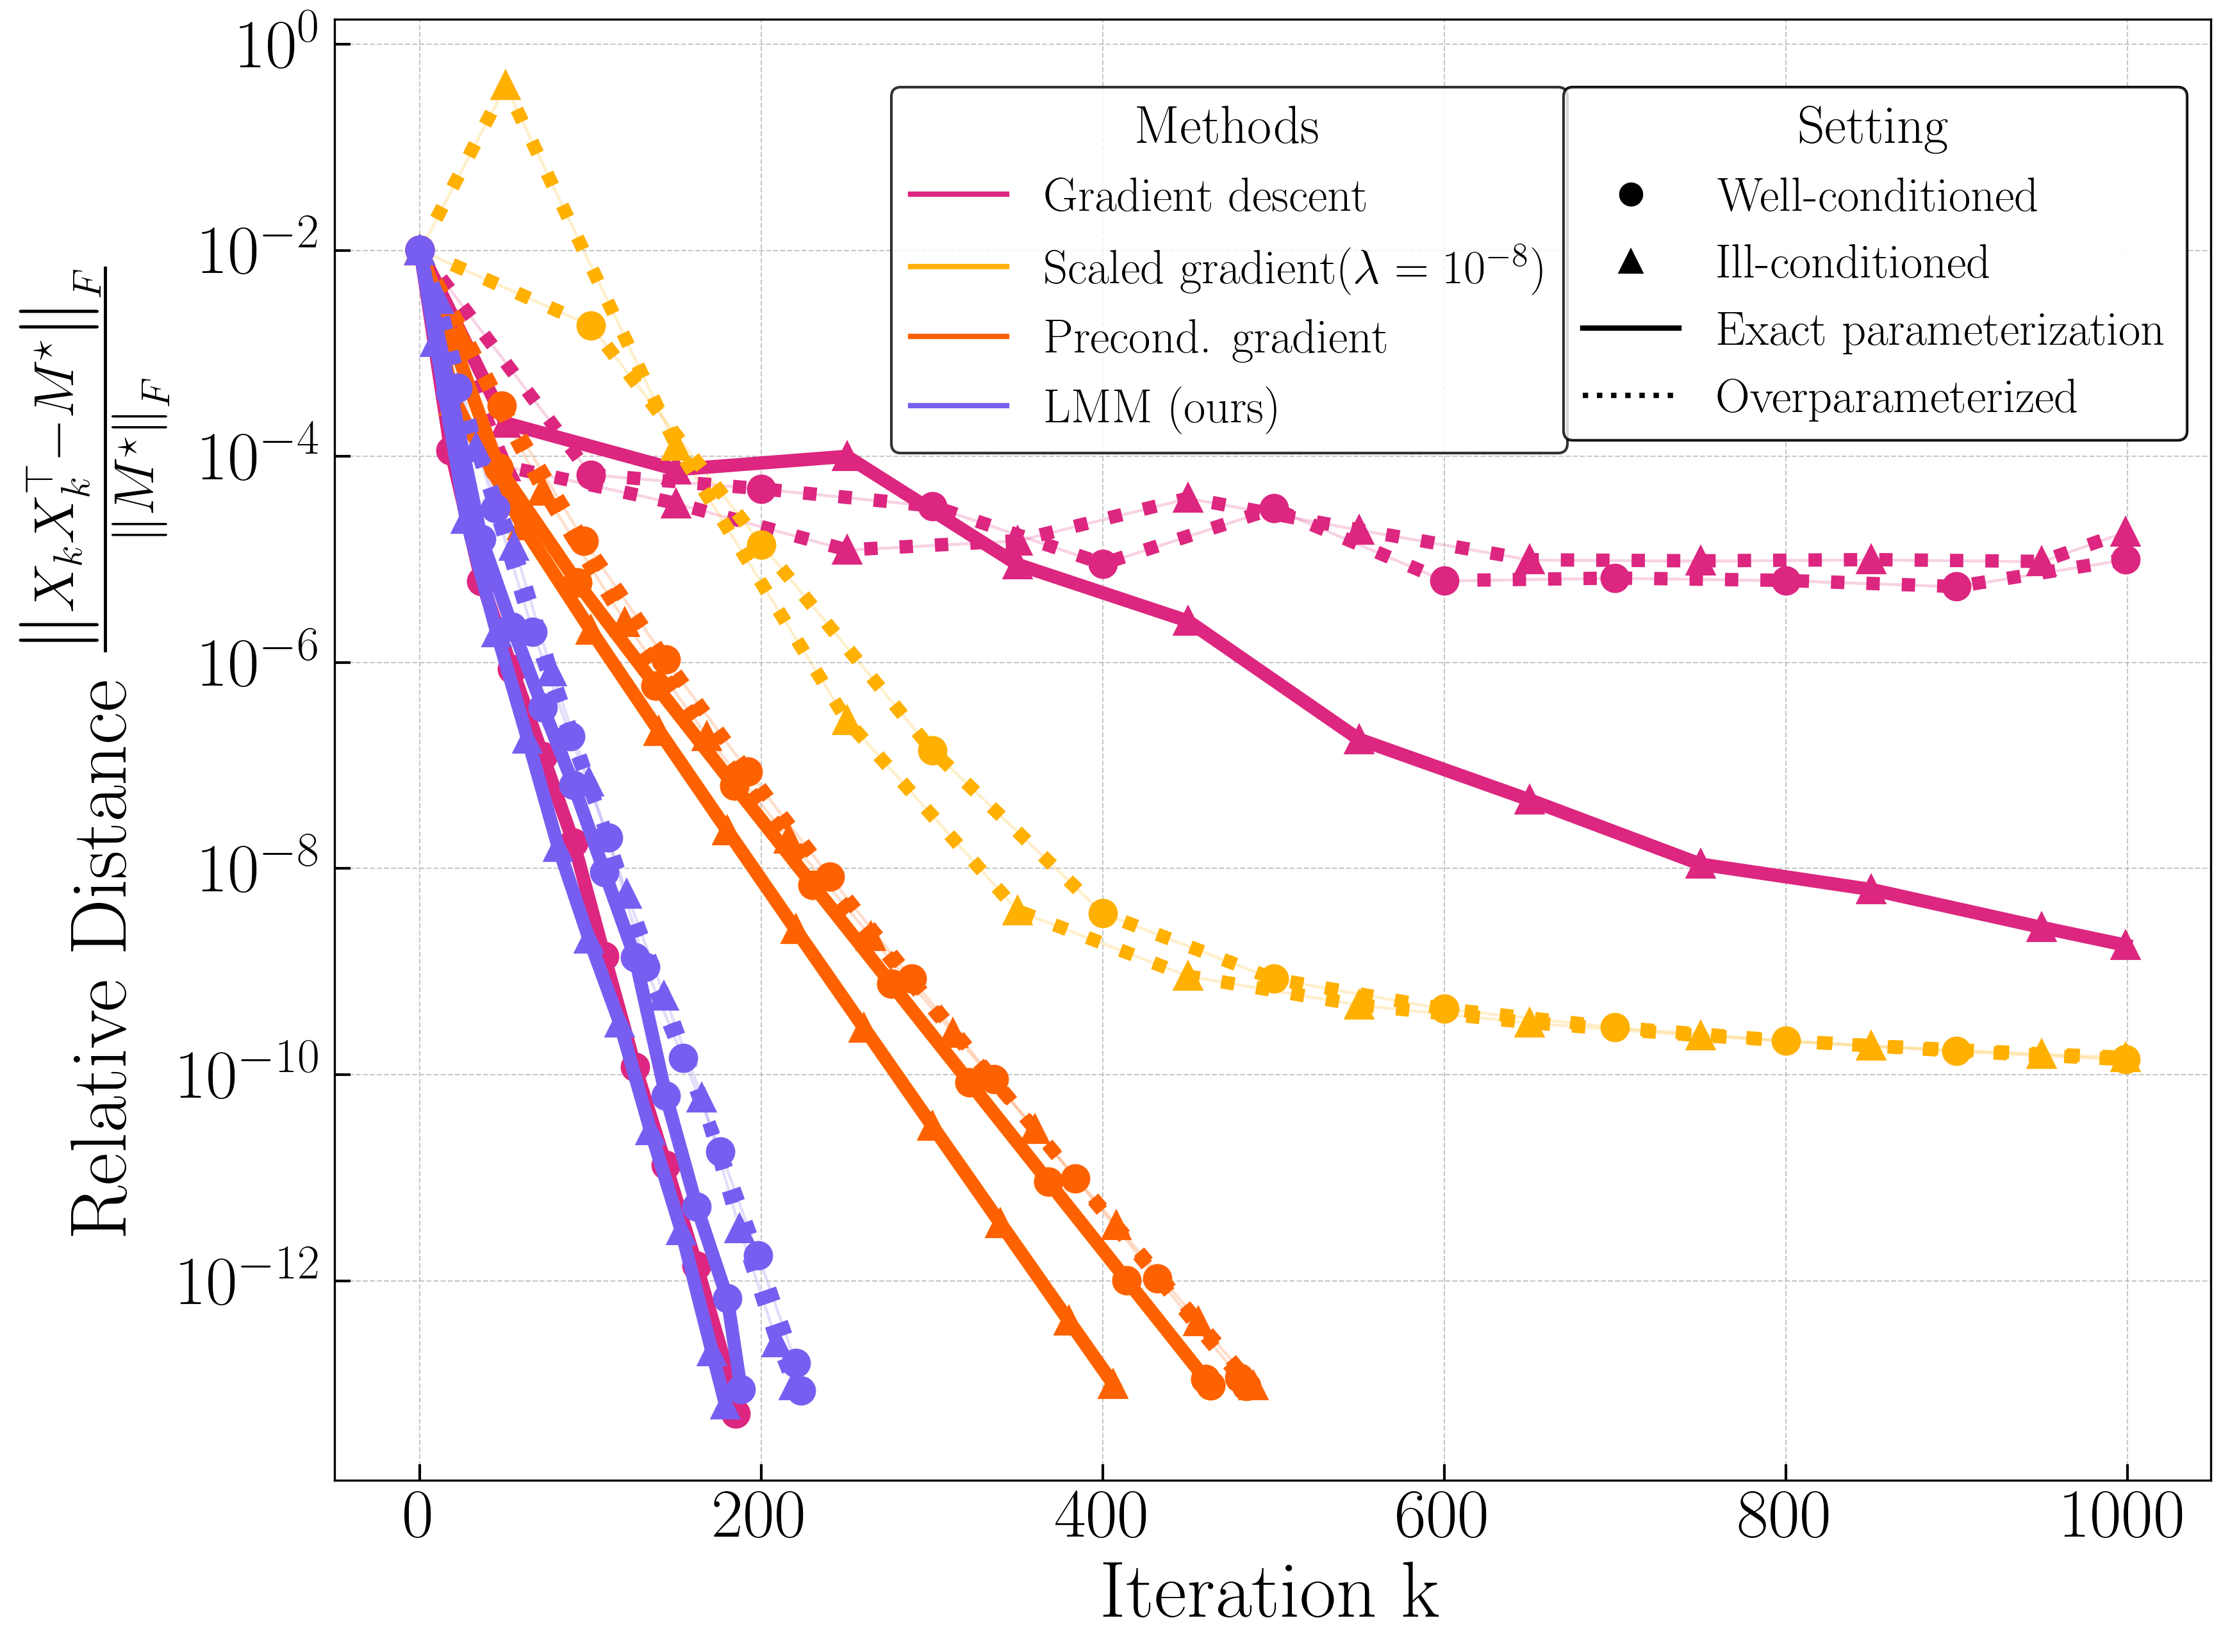

False


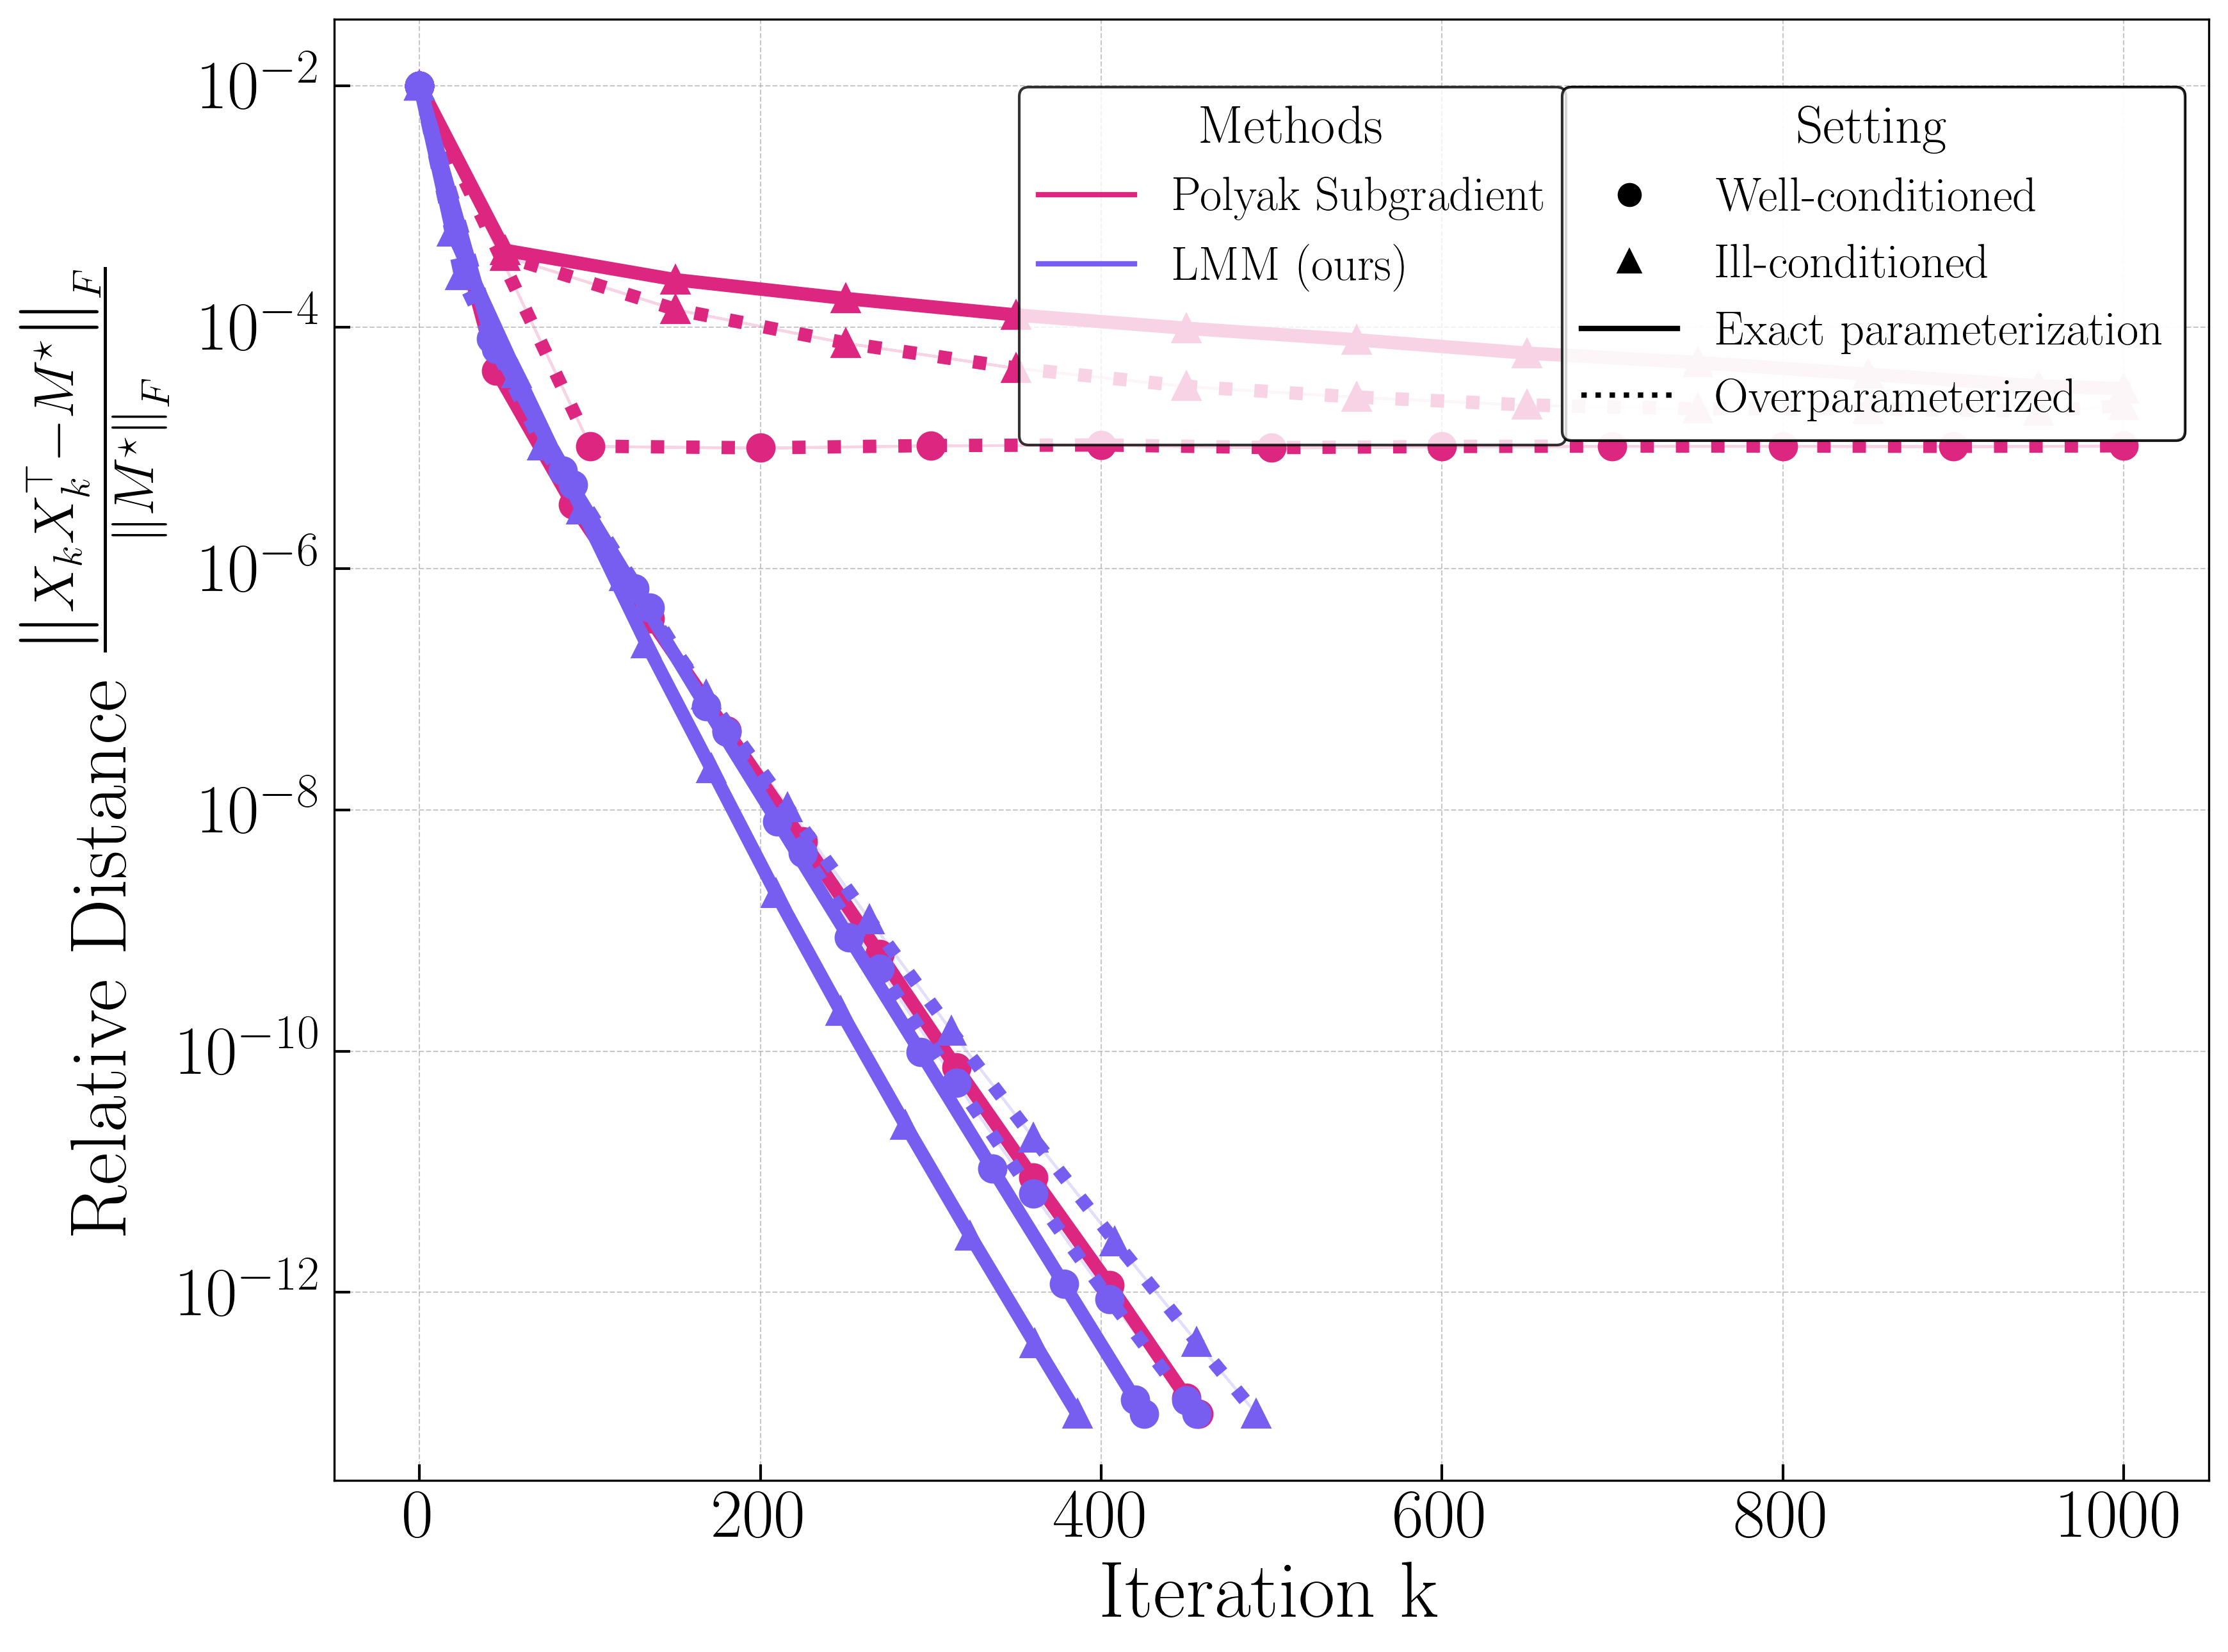

False


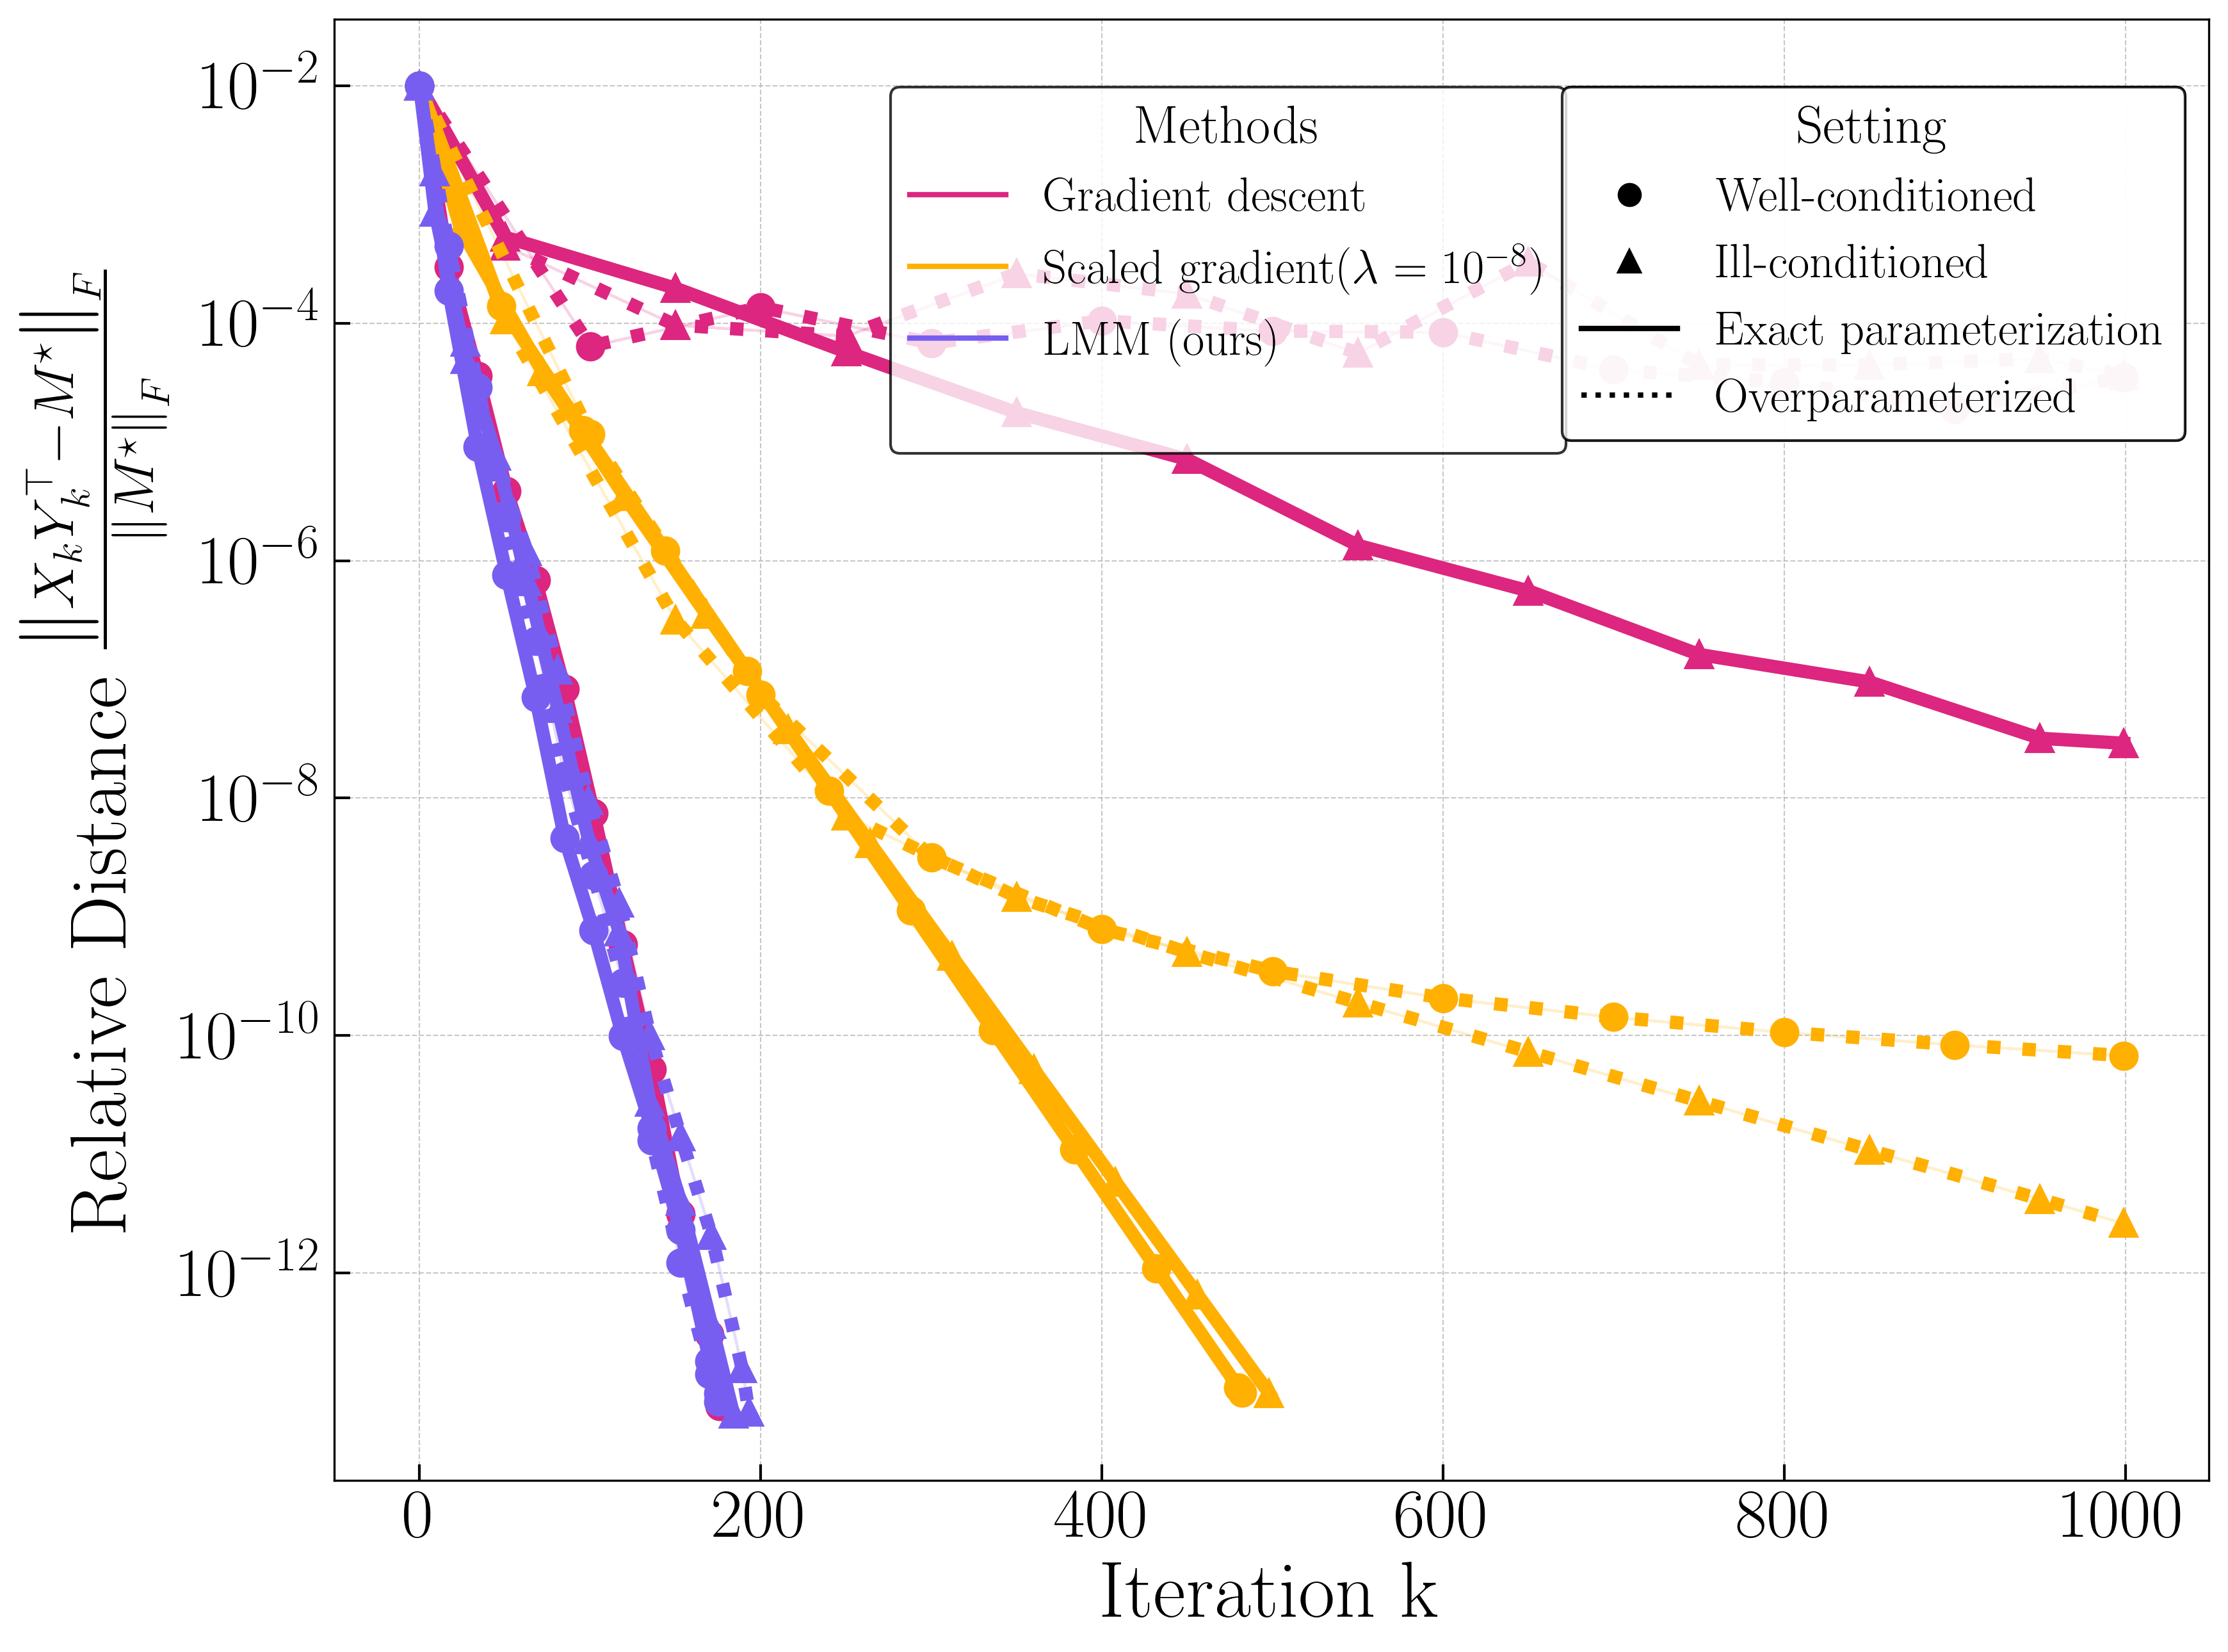

False


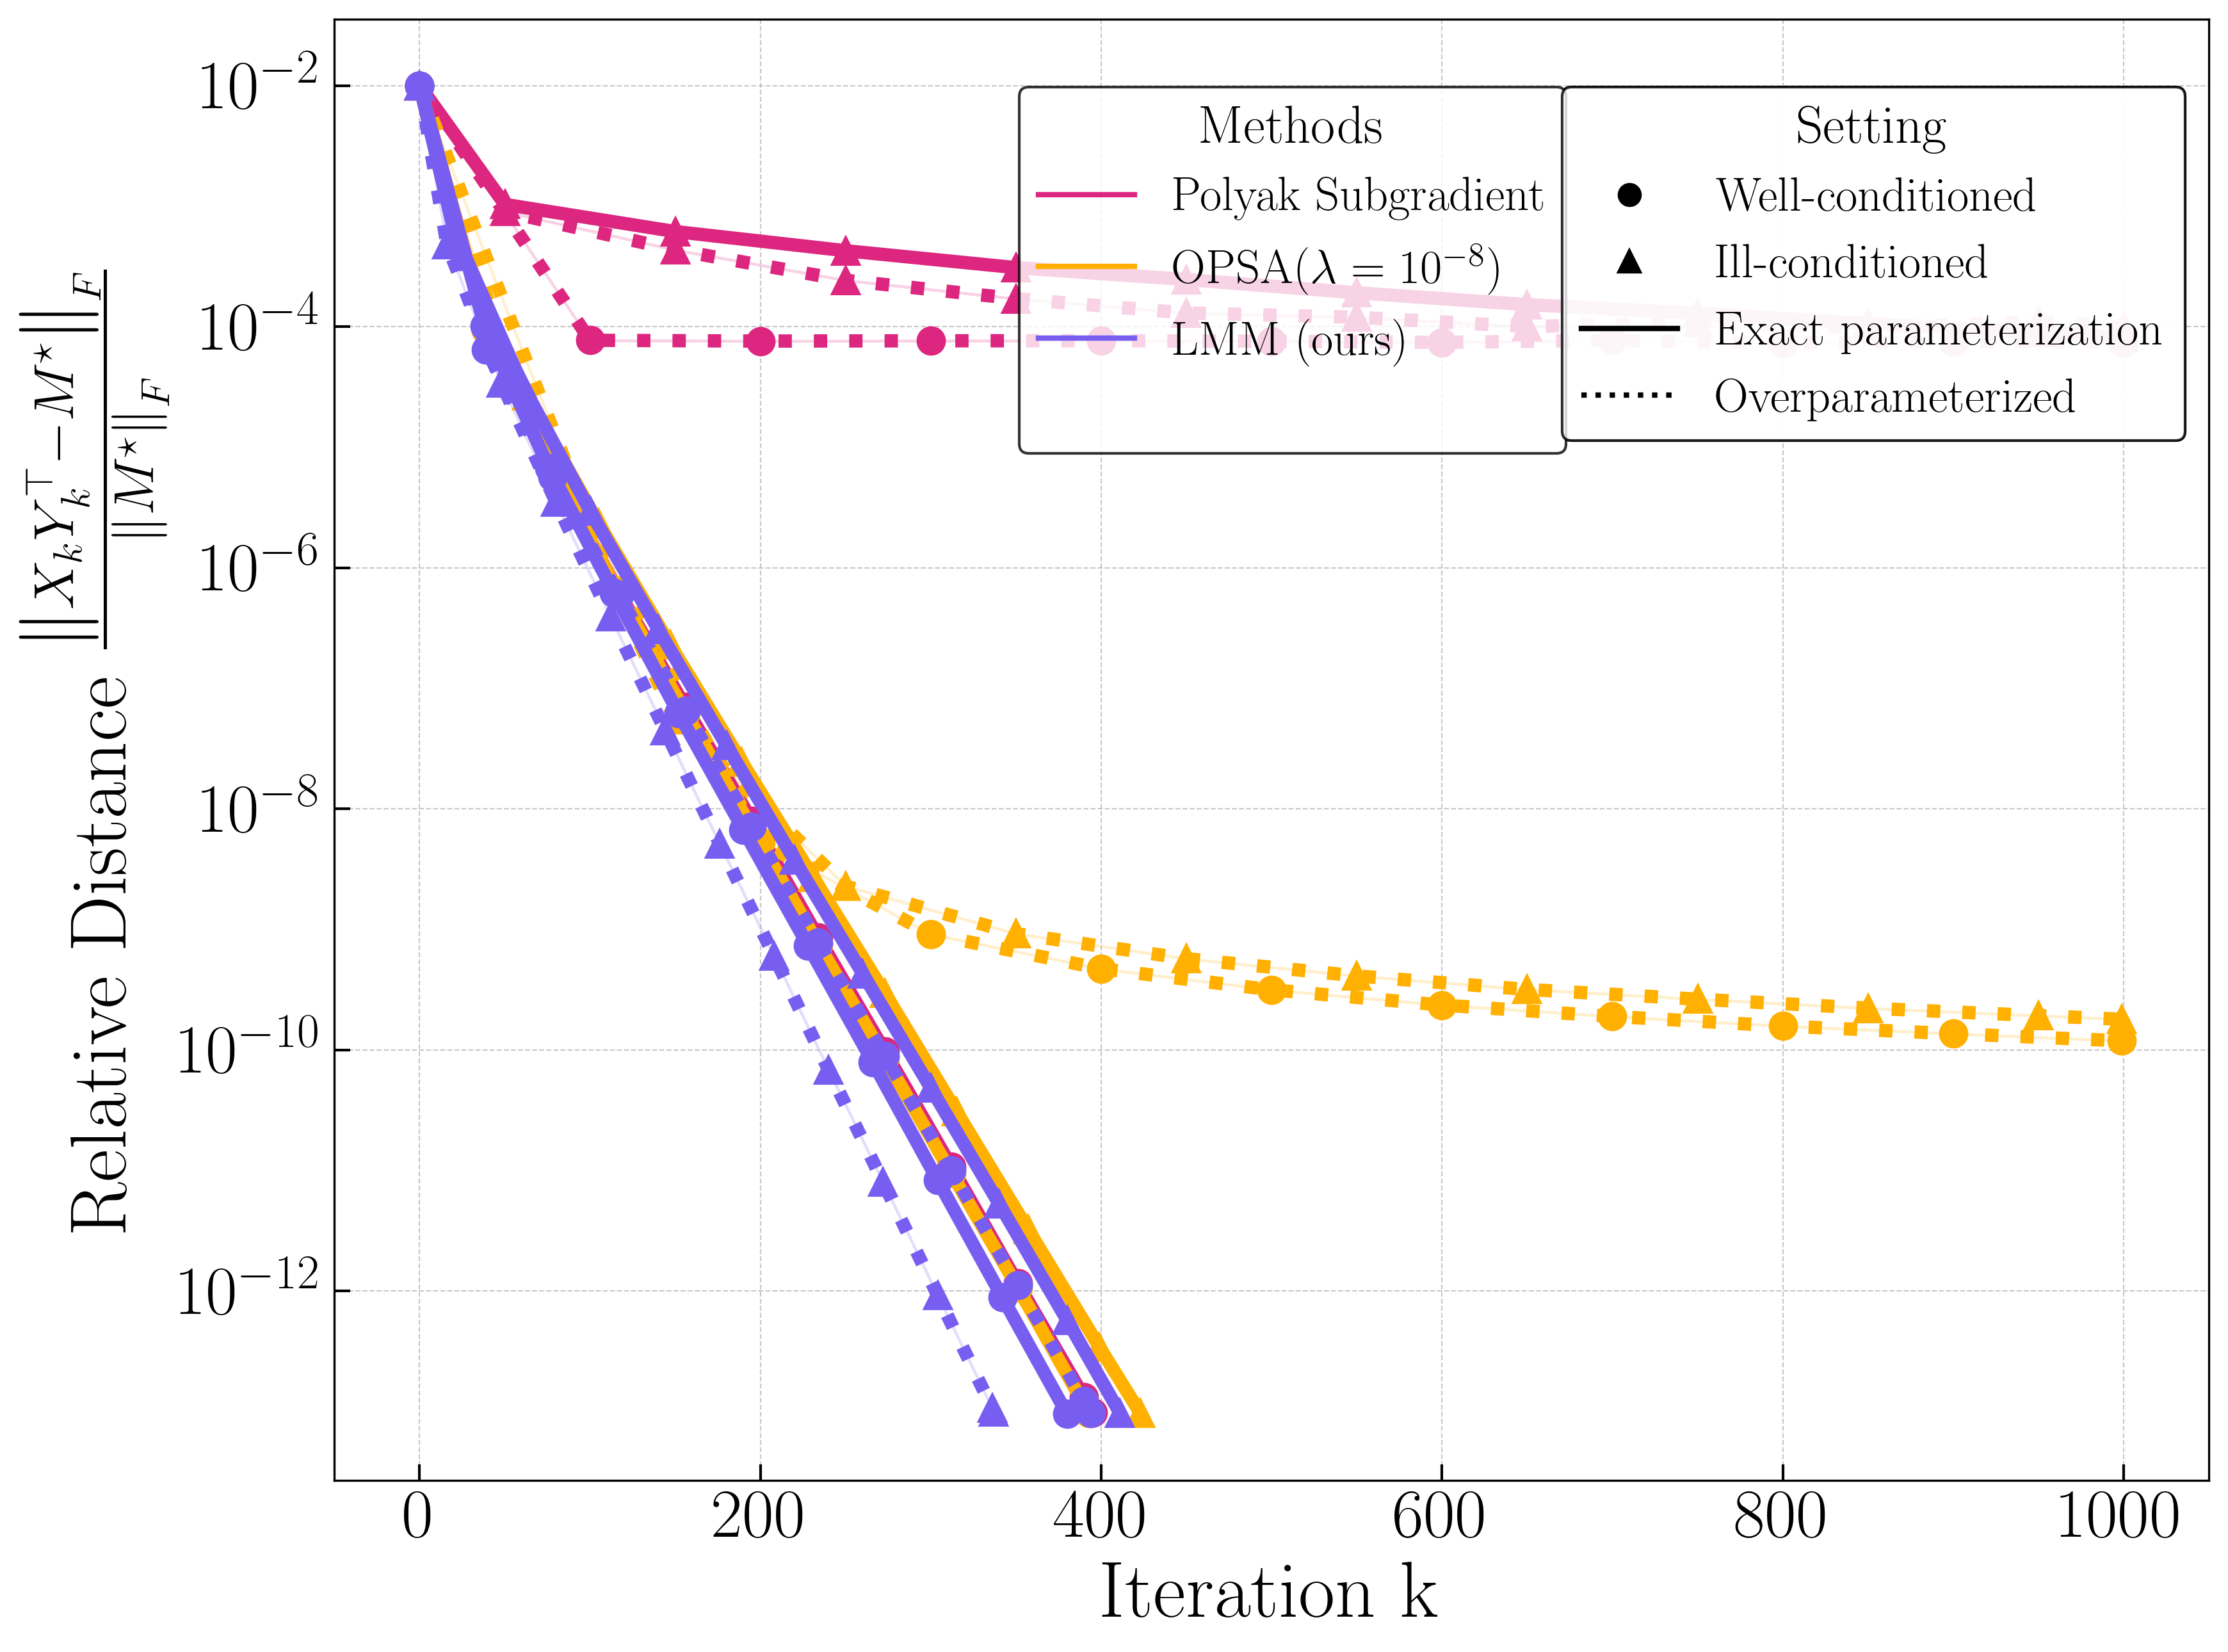

True


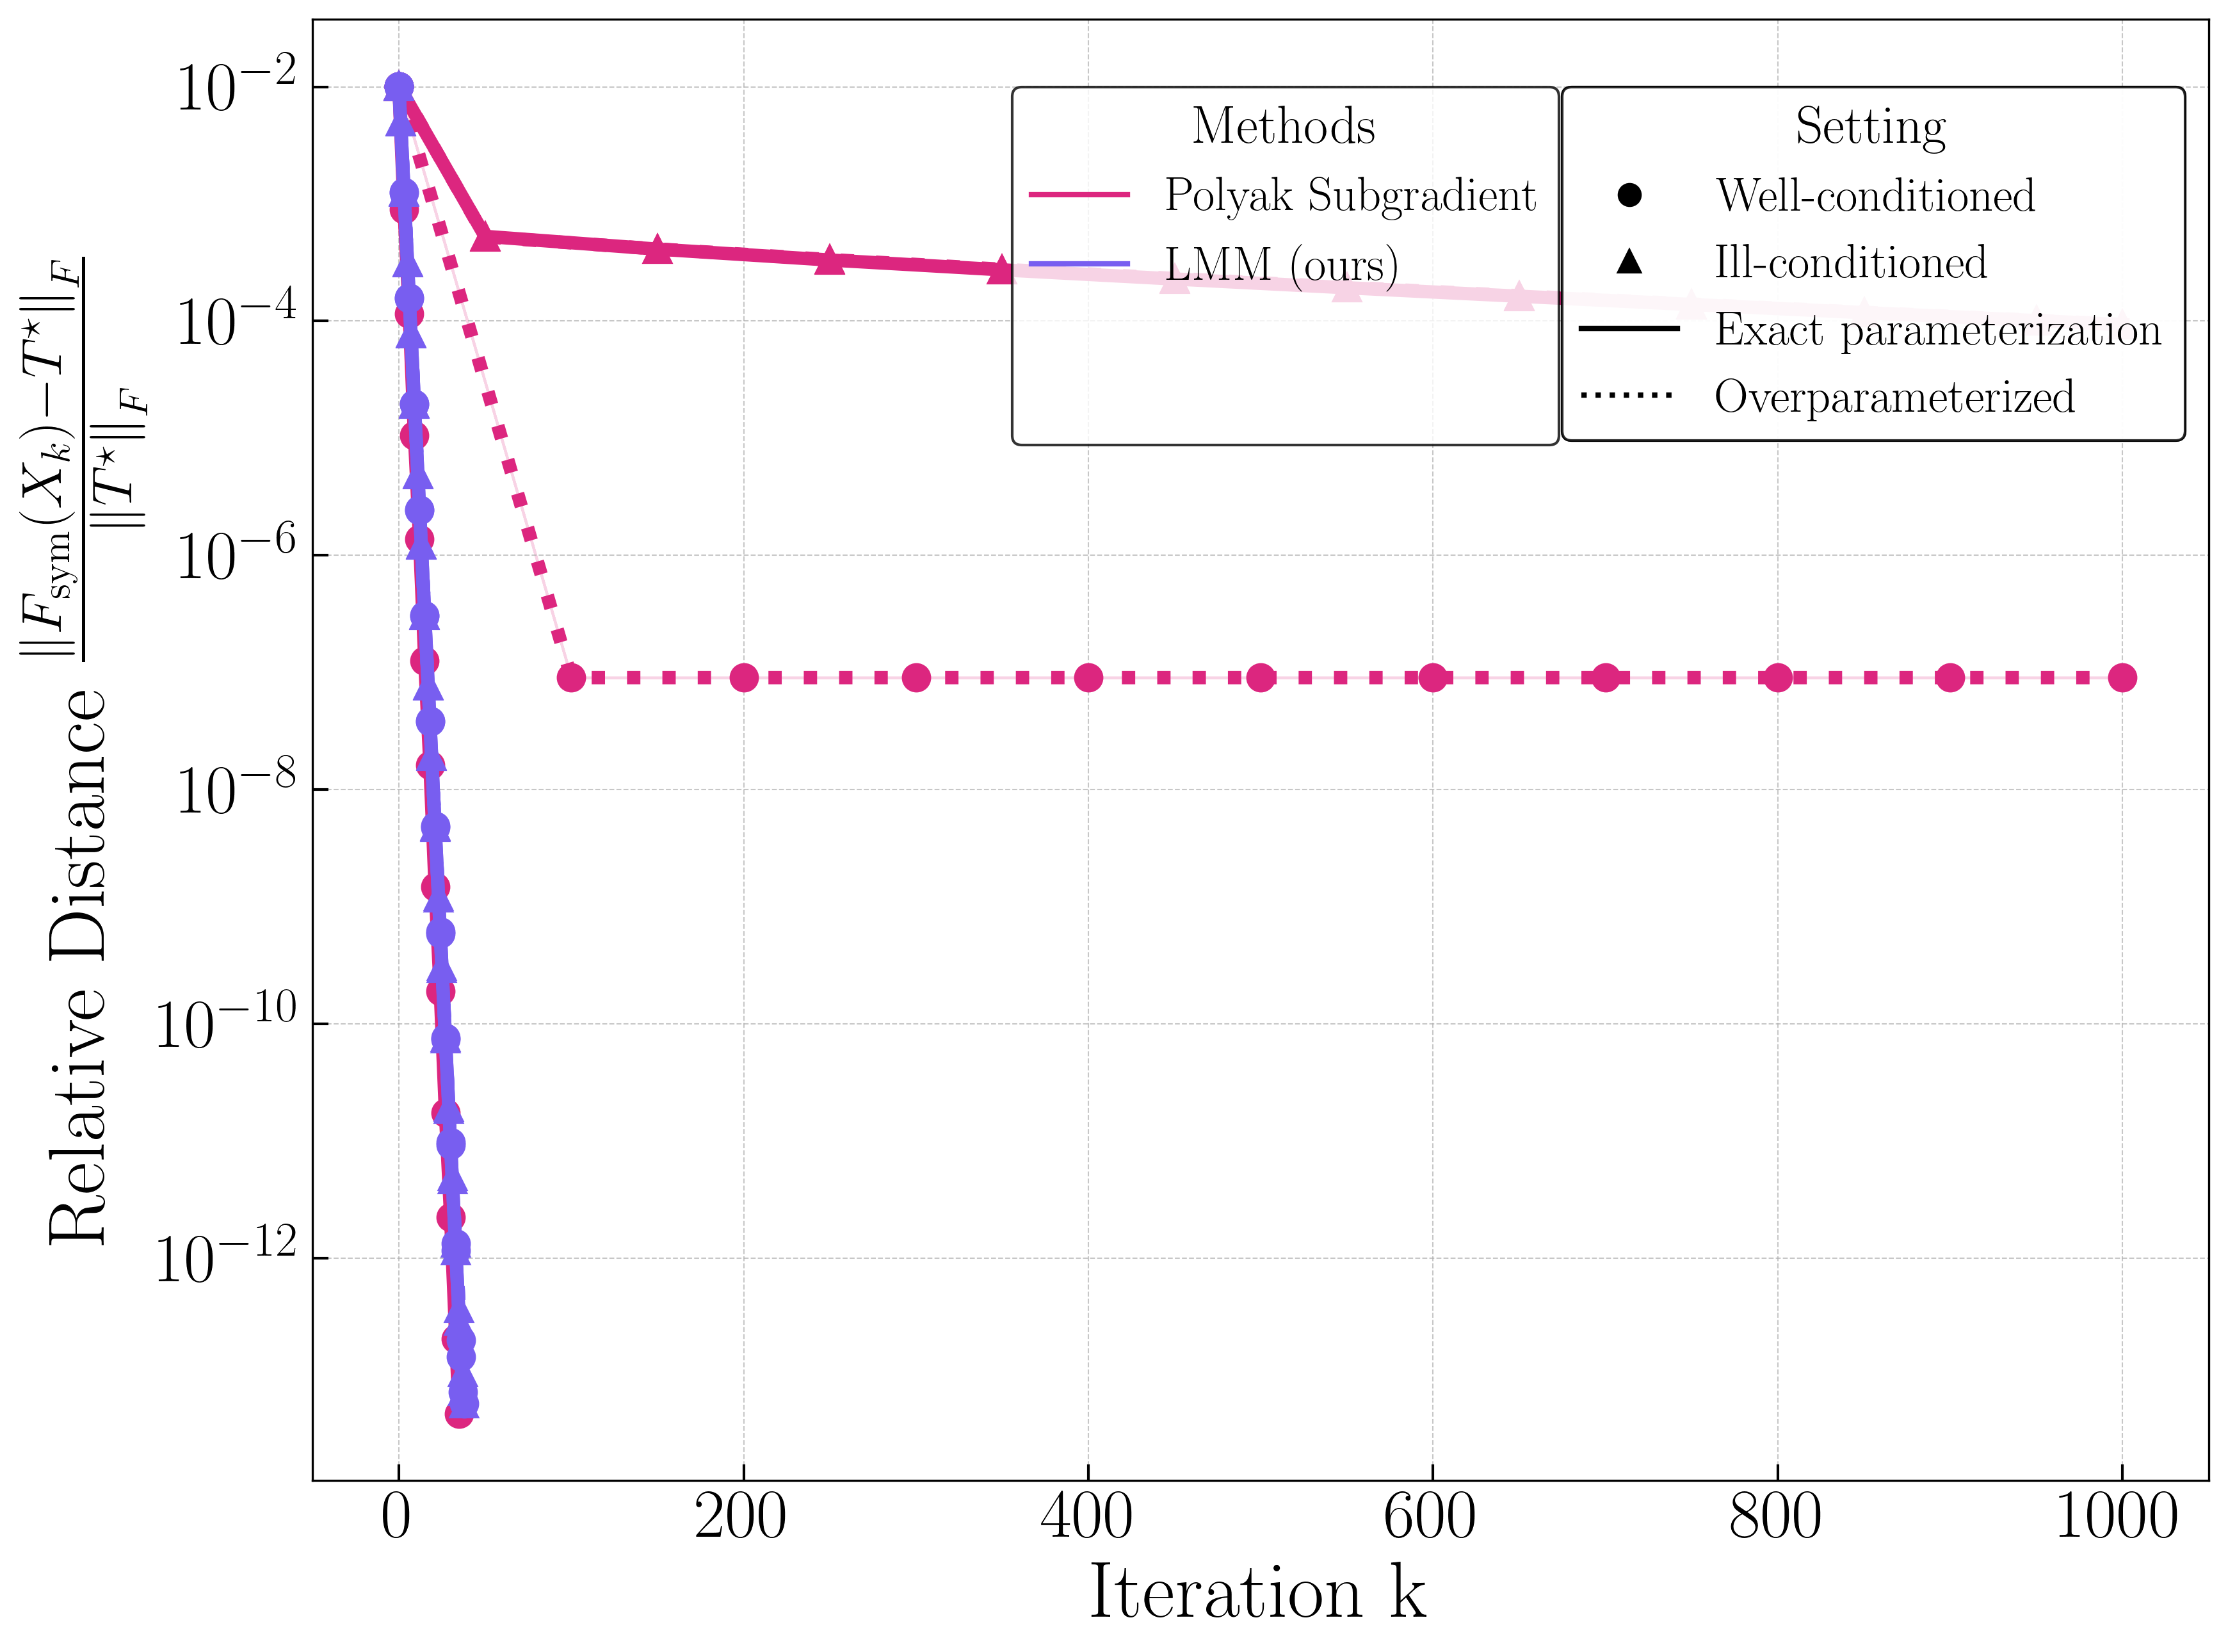

False


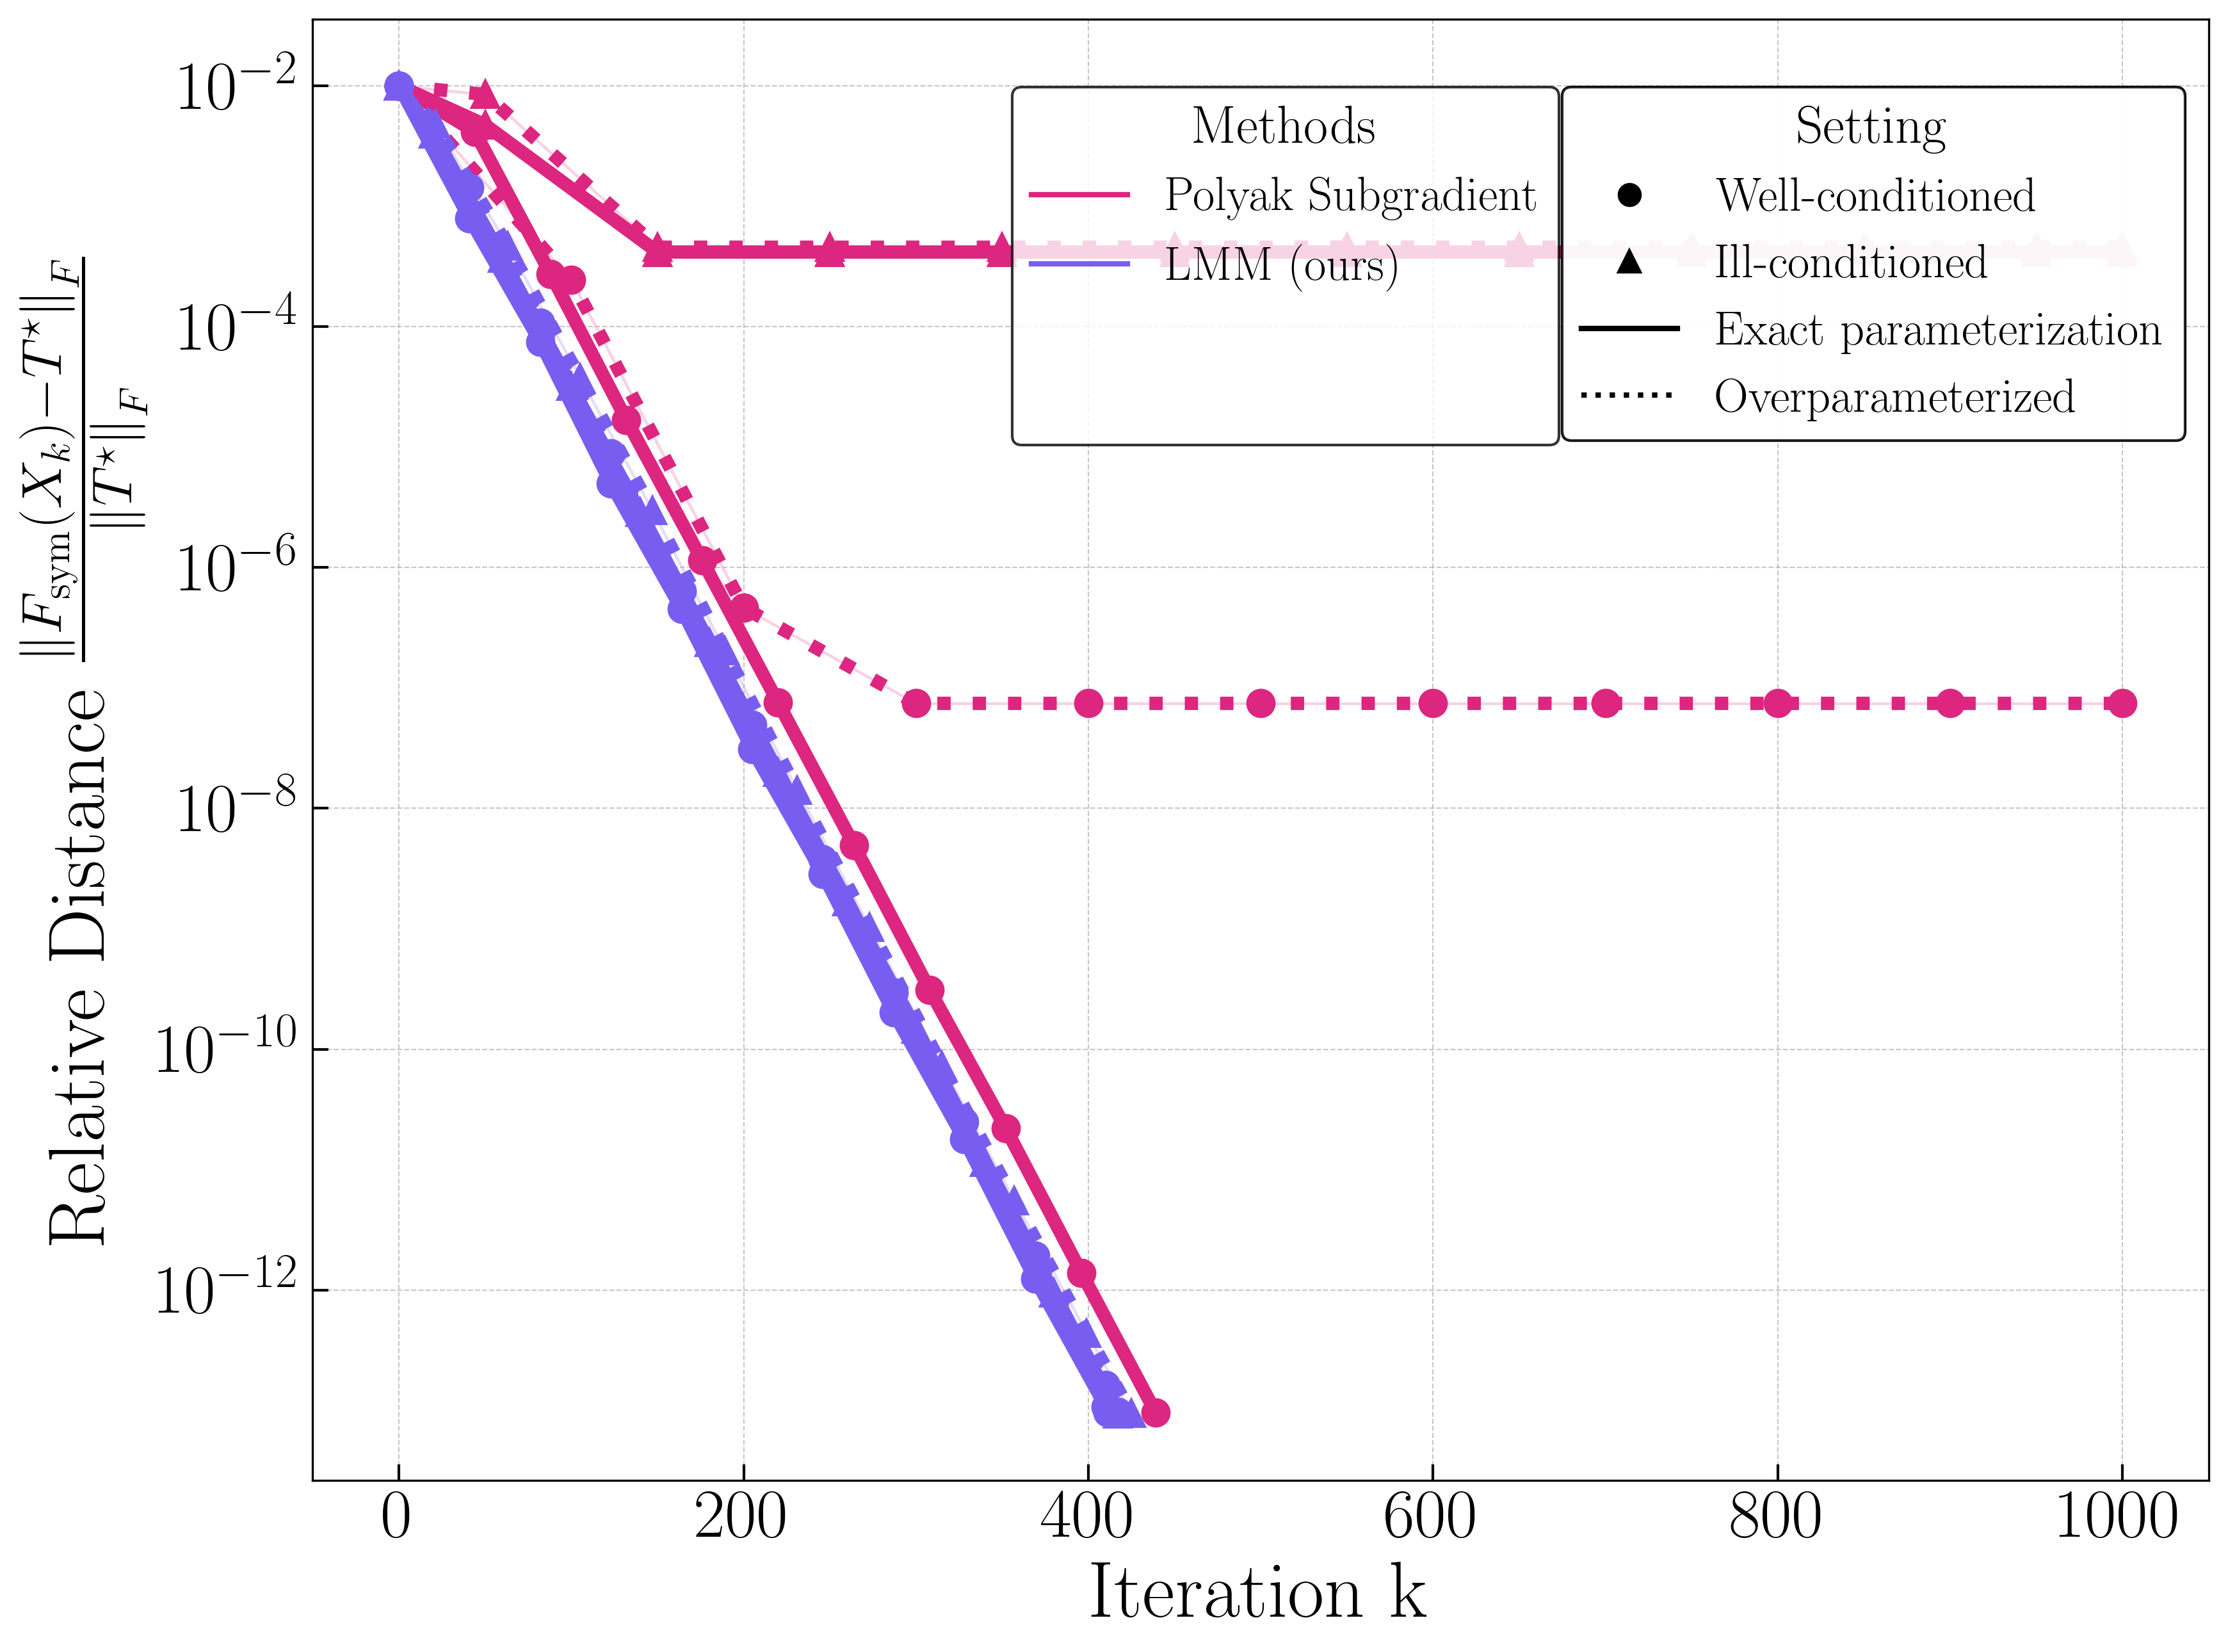

True


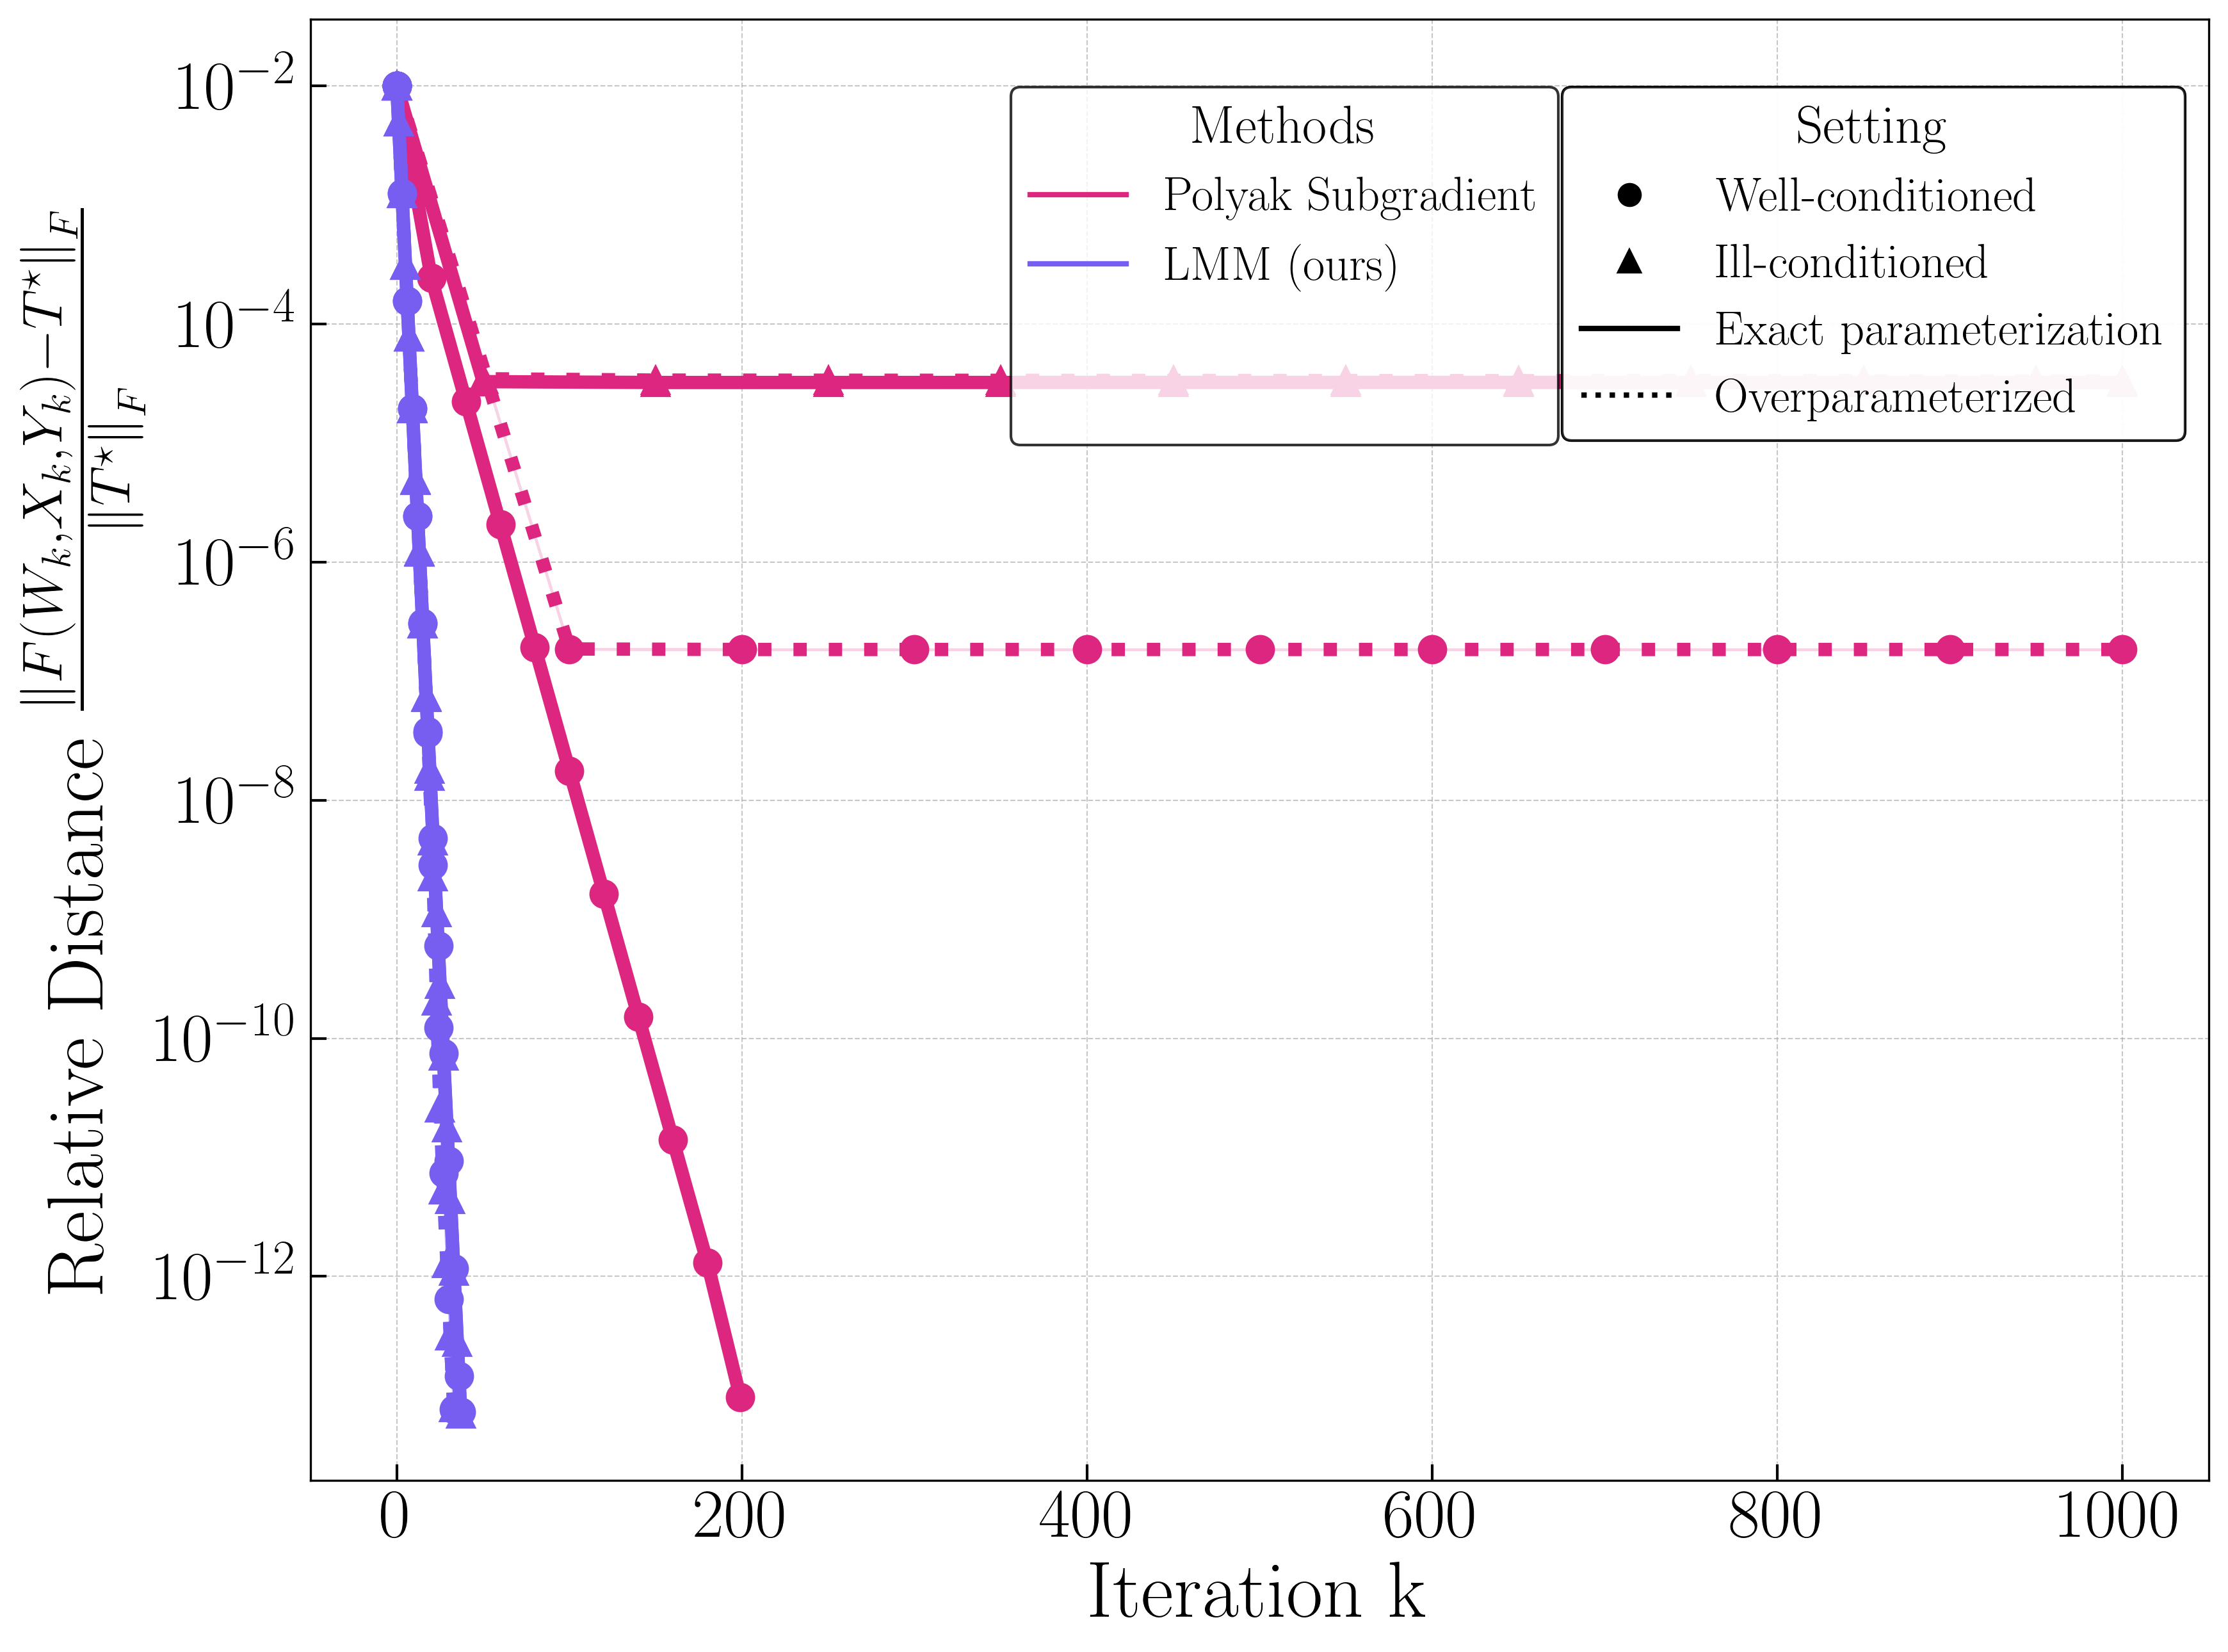

False


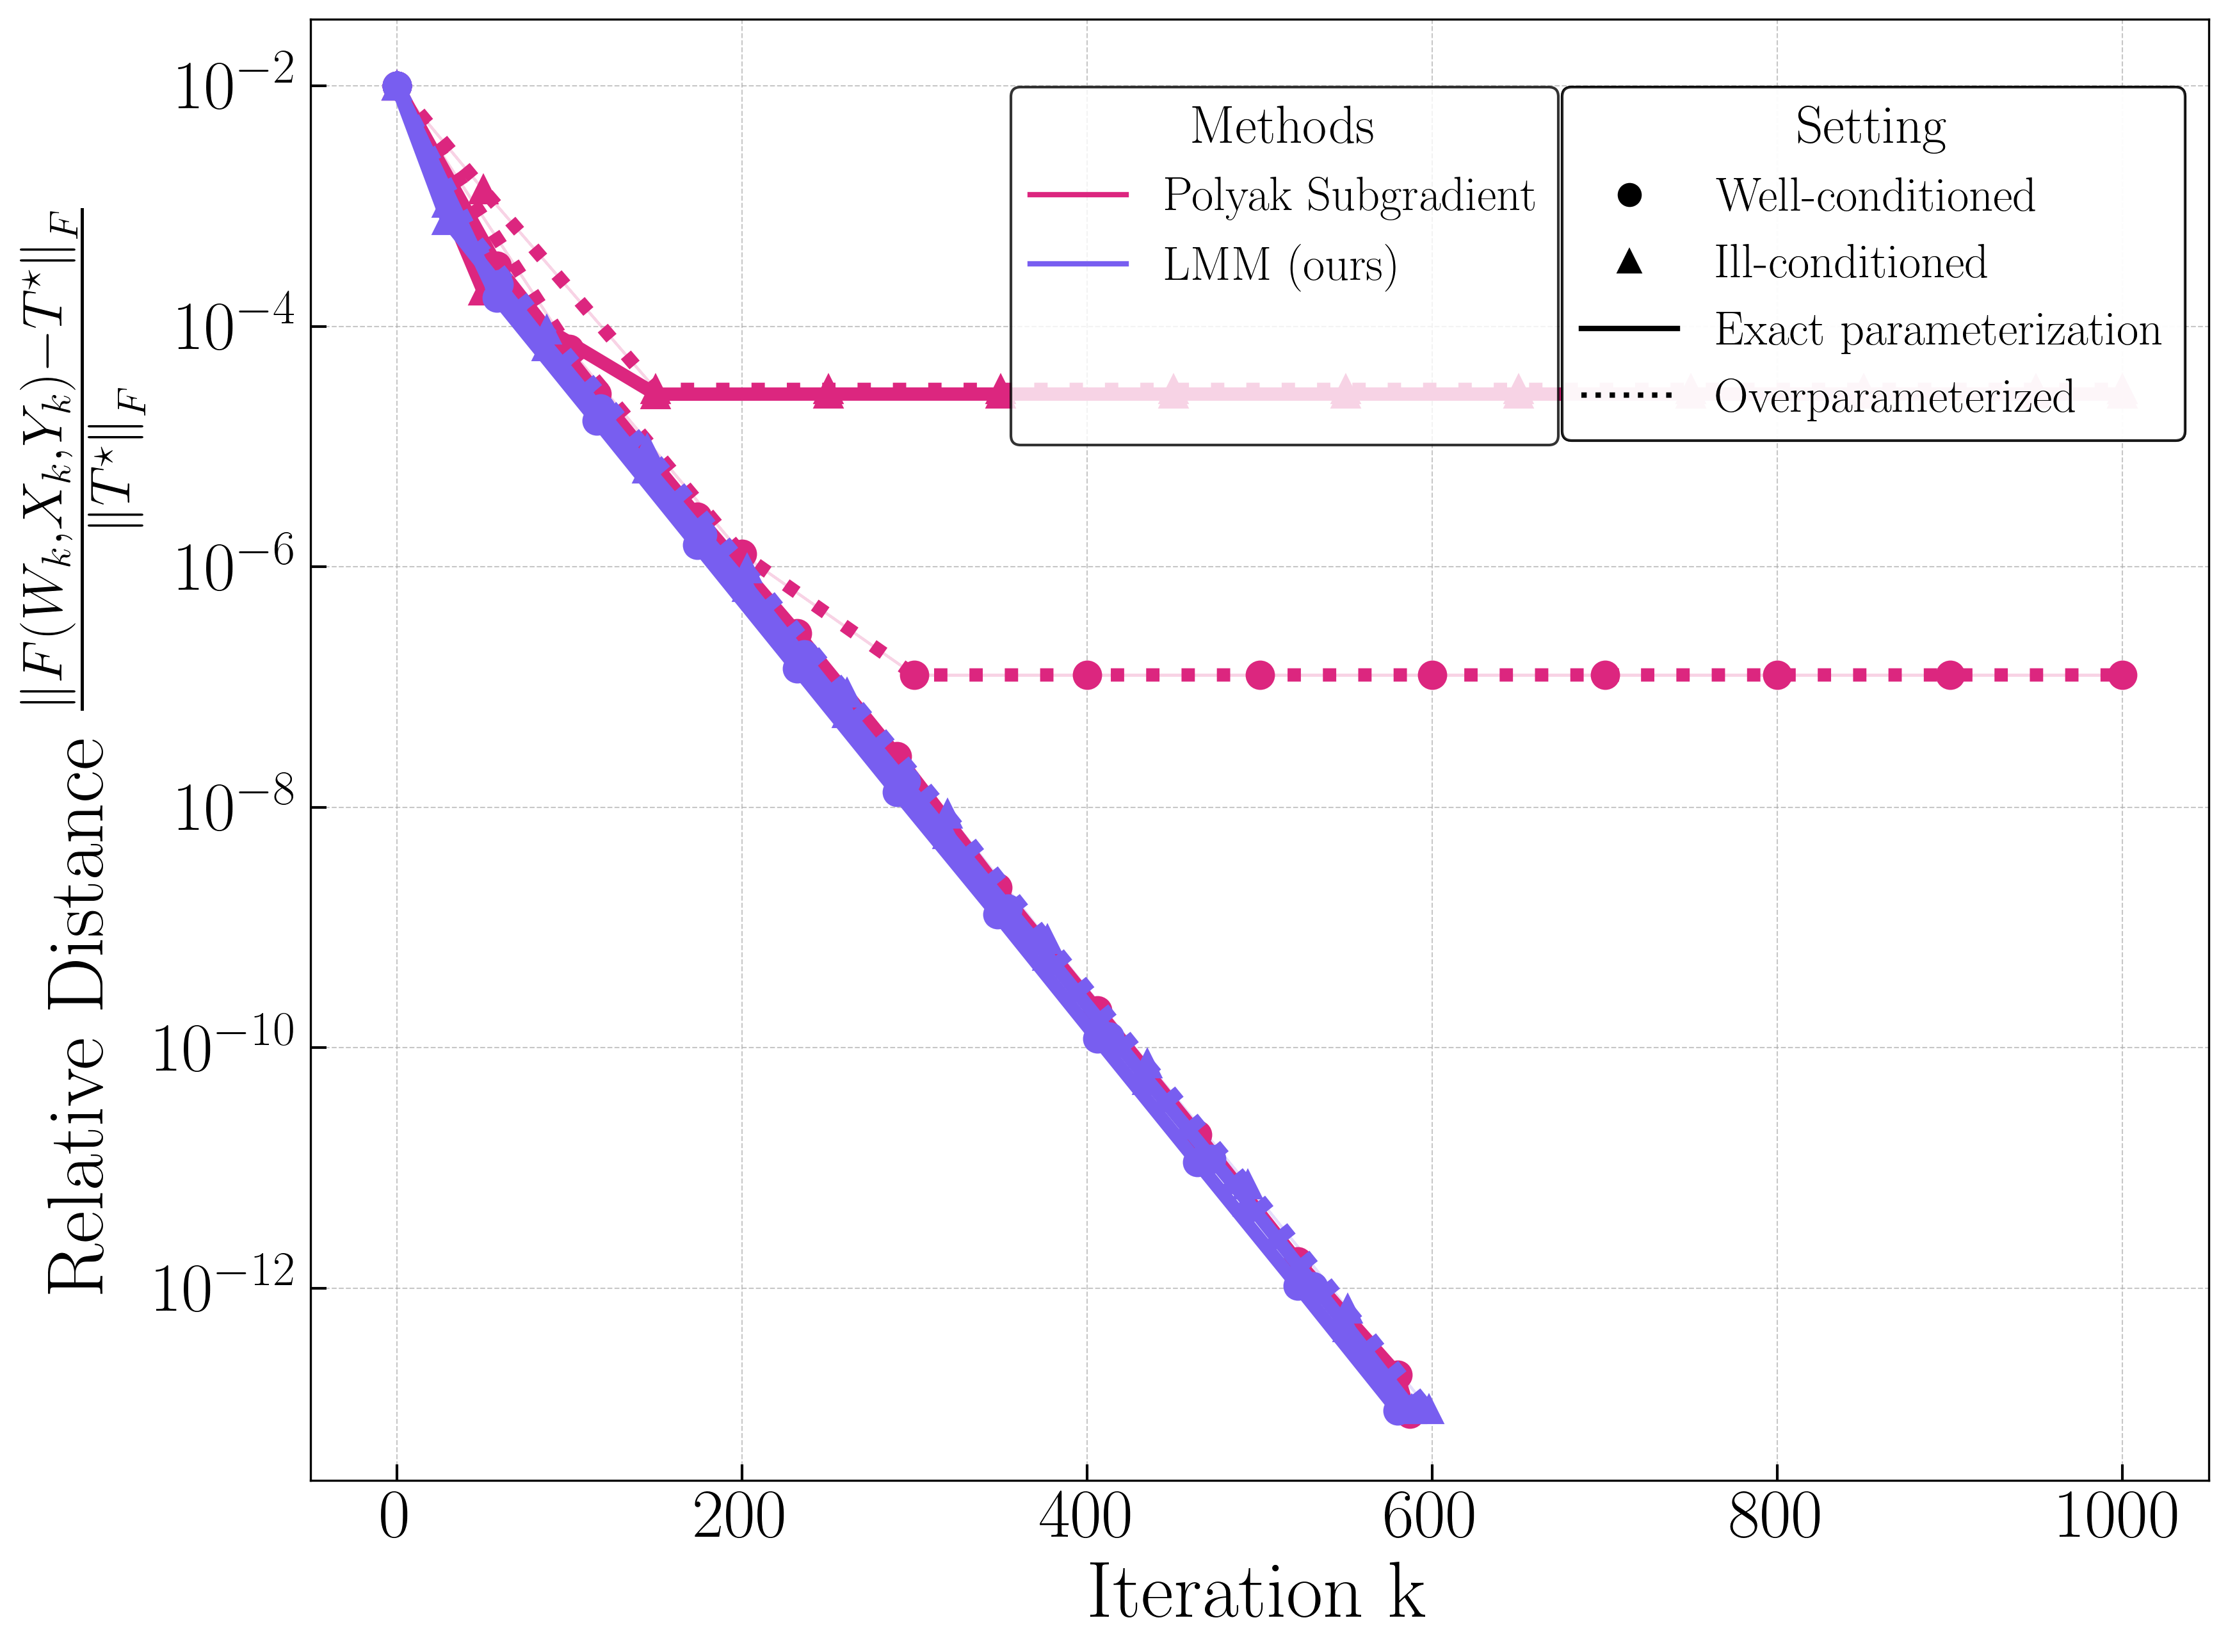

In [ ]:
for tensor in [False, True]:

  ds= [ 50  ] if tensor else [100,200]

  for d in ds:
    for sym in [True,False]:
      for loss_ord in [2,1]:
        symmetric = sym
        if tensor and loss_ord == 2:
            loss_ord = 0.5
        identity = True if (tensor and (loss_ord==2 or loss_ord==0.5) ) else False

        initial_relative_error = 10**-2

        n_iter = 1000
        n1 = n2 = n3 = 500 if identity else d
        print(identity)

        r_true = 2
        r=5
        m_div_r = (4 if not symmetric else 2)*d if not tensor else (30 if not symmetric else 5)*d
        base_dir = os.path.join(save_path, 'experiment_results/polyak')
        os.makedirs(base_dir, exist_ok=True)



        # experiment_setups: (overparameterization, condition number)
        experiment_setups = [(r_true,1),(r,100), (r_true,100), (r,1)]
        methods = ['Levenberg-Marquardt (ours)']

        if loss_ord == 2:
          to_add = ['Gradient descent']

          if not tensor and symmetric:
              to_add += ['Precond. gradient', 'Scaled gradient($\lambda=10^{-8}$)' ]
          elif not tensor:
              to_add += ['Scaled gradient($\lambda=10^{-8}$)' ]
        elif loss_ord == 1:
          to_add = ['Polyak Subgradient']
          if not tensor:
              to_add += [ 'OPSA($\lambda=10^{-8}$)' ] if not symmetric else []
        elif loss_ord == 0.5:
          to_add = ['Polyak Subgradient']
        methods = methods + to_add
        methods_test = methods

        # Run the methods.
        # if tensor and not identity:
        #   if symmetric:
        #      gamma, lambda_, q = 10**-3, 10**-5, 0.94
        #   else:
        #      gamma, lambda_, q = 10**-5, 10**-5, 0.96
        #   run_matrix_tensor_sensing_experiments(methods_test, experiment_setups, n1, n2, n3, r_true, m_div_r, identity, device,
        #             n_iter, base_dir, loßss_ord, initial_relative_error, symmetric,
        #             tensor=tensor, gamma_custom=(1 if not tensor else 0.5),  corr_level=0.1, geom_decay=True,
        #             gamma=gamma, lambda_=lambda_, q=q)
        # else:
        #   run_matrix_tensor_sensing_experiments(methods_test, experiment_setups, n1, n2, n3, r_true, m_div_r, identity, device,
        #    n_iter, base_dir, loss_ord, initial_relative_error, symmetric,
        #   tensor=tensor, gamma_custom=(1 if not tensor else 0.5))


        # Compute and plot errors.
        errs, stds,_ = collect_compute_mean(experiment_setups, loss_ord, r_true, False, methods,
                                        f'{"tensor" if tensor else "matrix"}{"sym" if symmetric else ""}', base_dir
                                          )
        plot_losses_with_styles(errs, stds, r_true, loss_ord, base_dir,
                                (('Symmetric ' if symmetric else 'Asymmetric ') +
                                ('Tensor' if tensor else 'Matrix')), 1, symmetric=symmetric, tensor=tensor,d=( n1 if identity else d))






# **Experiment 2: Geometrically Decaying Hyperparameters: Sensitivity Analysis**

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 20 11:12:31 2025

@author: aglabassi
"""



import numpy as np




run = False

tensor = False

symmetric = True

n=n1=n2=n3=10 if tensor  else 30
r_true = 2
m = n * r_true * 10
r = 5
initial_relative_error = 10**-3
rel_error_exp = 8
rel_epsilon_stop = 10**(-1*rel_error_exp)
tests = [ (2,1),(2,100), (5,100)]
problems = [ ' ' ] #ignore this

methods = [ 'Polyak Subgradient', 'Gauss-Newton','Levenberg-Marquardt (ours)']
corruption_levels = [0]
qs = [ 0.95, 0.96, 0.97 ]
lambdas = [ 10**-5 ]
gammas = [10**i for i in range(1,0, -1)] + [10**-i for i in range(0,9)]
K  = 1000
n_trial = 100

base_dir = os.path.join(save_path, 'experiment_results/hyperparameter_sensitivity')
os.makedirs(base_dir, exist_ok=True)


if run:
    for corr_level, (r_test, c), q in product(corruption_levels, tests, qs):

        to_be_plotted = dict( (problem, dict( (method,np.zeros((len(lambdas), len(gammas)), dtype=object)) for method in methods)) for problem in problems )

        for problem in problems:
            for i, j in product(range(len(lambdas)), range(len(gammas))):
                last_indexes = dict(  (method, [] ) for method in methods)

                for _ in range(n_trial):
                    # Generate losses depending on the problem
                    print(f'Test {gammas[j]}')
                    outputs = run_matrix_tensor_sensing_experiments(methods, [(r_test, c)], n1, n2, n3, r_true, m, False, device,
                            K, base_dir, 1, initial_relative_error, symmetric,
                            tensor=tensor, corr_level=corr_level, q=q, lambda_=lambdas[i], gamma=gammas[j], geom_decay=True)


                    for method in methods:
                        losses = outputs[method]
                        # Find the first iteration index where losses < rel_epsilon_stop
                        idx = np.where(np.array(losses) < rel_epsilon_stop)[0]
                        last_index = idx[0] if len(idx) > 0 else K
                        last_indexes[method].append(last_index)

                for method in methods:
                    median_last_index = np.median(last_indexes[method])
                    shaded = np.percentile(last_indexes[method], [5, 95])
                    to_be_plotted[problem][method][i, j] = (median_last_index, tuple(shaded))
            save(to_be_plotted[problem], os.path.join(base_dir, f'to_be_plotted_{problem}_{corr_level}_{r_test}_{c}_{q}.pkl'))

# Call the plotting function
font_size=30
for corr_level, (r_test, c), q in product(corruption_levels, tests, qs):
    for problem, method  in product(problems, methods):
        to_be_plotted = load(os.path.join(base_dir, f'to_be_plotted_{problem}_{corr_level}_{r_test}_{c}_{q}.pkl'))
        if 'Subgradient descent' in to_be_plotted:
          to_be_plotted['Polyak Subgradient'] = to_be_plotted.pop('Subgradient descent')

        plot_results_sensitivity(to_be_plotted, corr_level, q, r_test, c, gammas, lambdas, font_size, rel_error_exp, problem, base_dir)



# **Experiment 3: Sensing with Outliers**

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 20 11:12:31 2025

@author: aglabassi
"""

import numpy as np



run = True
tensor=False
symmetric = True
n= n1 = n2 = n3 = 10 if tensor else 30
r_true = 2
loss_ord = 1

trials = 20
n_trial_div_n_cpu = 1

K = 500
problem = ''


methods = ['Polyak Subgradient','Gauss-Newton', 'Levenberg-Marquardt (ours)']
methods_test = methods
methods_all = methods

init_radius_ratio =10**-2
end_ratio = 10**-8
keys_all = [(2,100)] #keep one
keys_test = keys_all

ms = [ i*2*n for i in range(10,20)]
cor_interval= 0.025
corr_ranges = [ [l, l+cor_interval]  for l in np.arange(0, 0.5, cor_interval)]

base_dir = base_dir = os.path.join(save_path, 'experiment_results/phase_transition')
os.makedirs(base_dir, exist_ok=True)
save_path_file = os.path.join(base_dir,f'{keys_test[0]}_{problem}.pkl' )

if run:
    success_matrixes = dict( (method, np.zeros((len(ms), len(corr_ranges)) )) for method in methods)
    for i,m in enumerate(ms):
        for j,corr_range in enumerate(corr_ranges):

            success_counters = dict((method, 0) for method in methods)

            for _ in range(trials):
                corr_factor = (corr_range[1] -corr_range[0]) *np.random.rand() + corr_range[0]
                print(corr_factor)

                outputs = run_matrix_tensor_sensing_experiments(methods_test, keys_all, n1, n2, n3, r_true, m, False, device,
                            K, base_dir, loss_ord, init_radius_ratio, symmetric,
                            tensor=tensor, corr_level=corr_factor, geom_decay=True, q=0.97, lambda_=1e-5, gamma=1e-5)




                for method in methods:
                    if outputs[method][-1] <= end_ratio:
                        success_counters[method] +=1

            for method in methods:
                success_matrixes[method][i,j] = success_counters[method]/trials

    # Save success matrix

    save(success_matrixes, save_path_file)

# Load success matrix for verification or further processing
loaded_success_matrixes = load(save_path_file)

plot_transition_heatmap(
    success_matrixes=loaded_success_matrixes,
    d_trials=ms,
    n=n,
    base_dir=base_dir,
    keys = keys_test[0],
    problem=problem,
)
